# Import packages

In [1]:
import warnings
import scirpy as ir
warnings.simplefilter(action='ignore', category=FutureWarning)
from mousipy import translate
import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import muon as mu
%matplotlib inline
from glob import glob
import anndata
sc.set_figure_params(dpi=100)
import warnings
warnings.filterwarnings('ignore')
import scprep
from statannot import add_stat_annotation

2023-11-28 17:01:34.943759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-28 17:01:34.943782: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import Object Concatenated

In [2]:
adata = sc.read("/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/H5ad/Part2_TcellCD4_raw.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 6409 × 16482
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'batch', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'Gene type', 'Gene description', 'n_cells'
    layers: 'log', 'log1', 'raw'

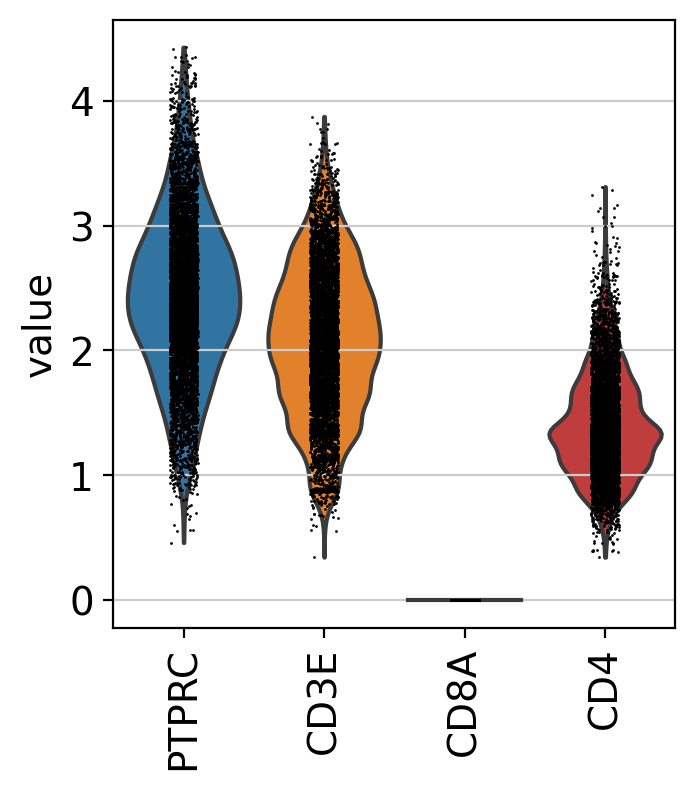

In [4]:
sc.pl.violin(adata, keys=['PTPRC','CD3E','CD8A','CD4'],  rotation=90)

In [5]:
adata.layers['log'] =  adata.X.A

In [6]:
sc.pp.filter_genes(adata, min_cells=3)

# Feature Selection

In [7]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)
# This saves the original set of genes 
adata.raw = adata

adata = adata[:,adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

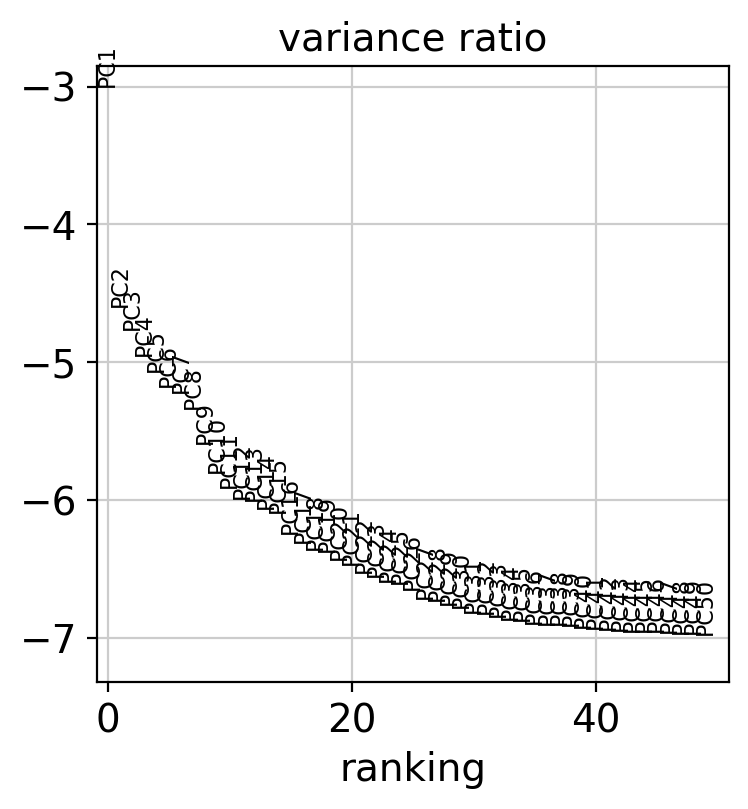

In [8]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, save='') # scanpy generates the filename automatically

# Umap before Correction

In [9]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=0.5)

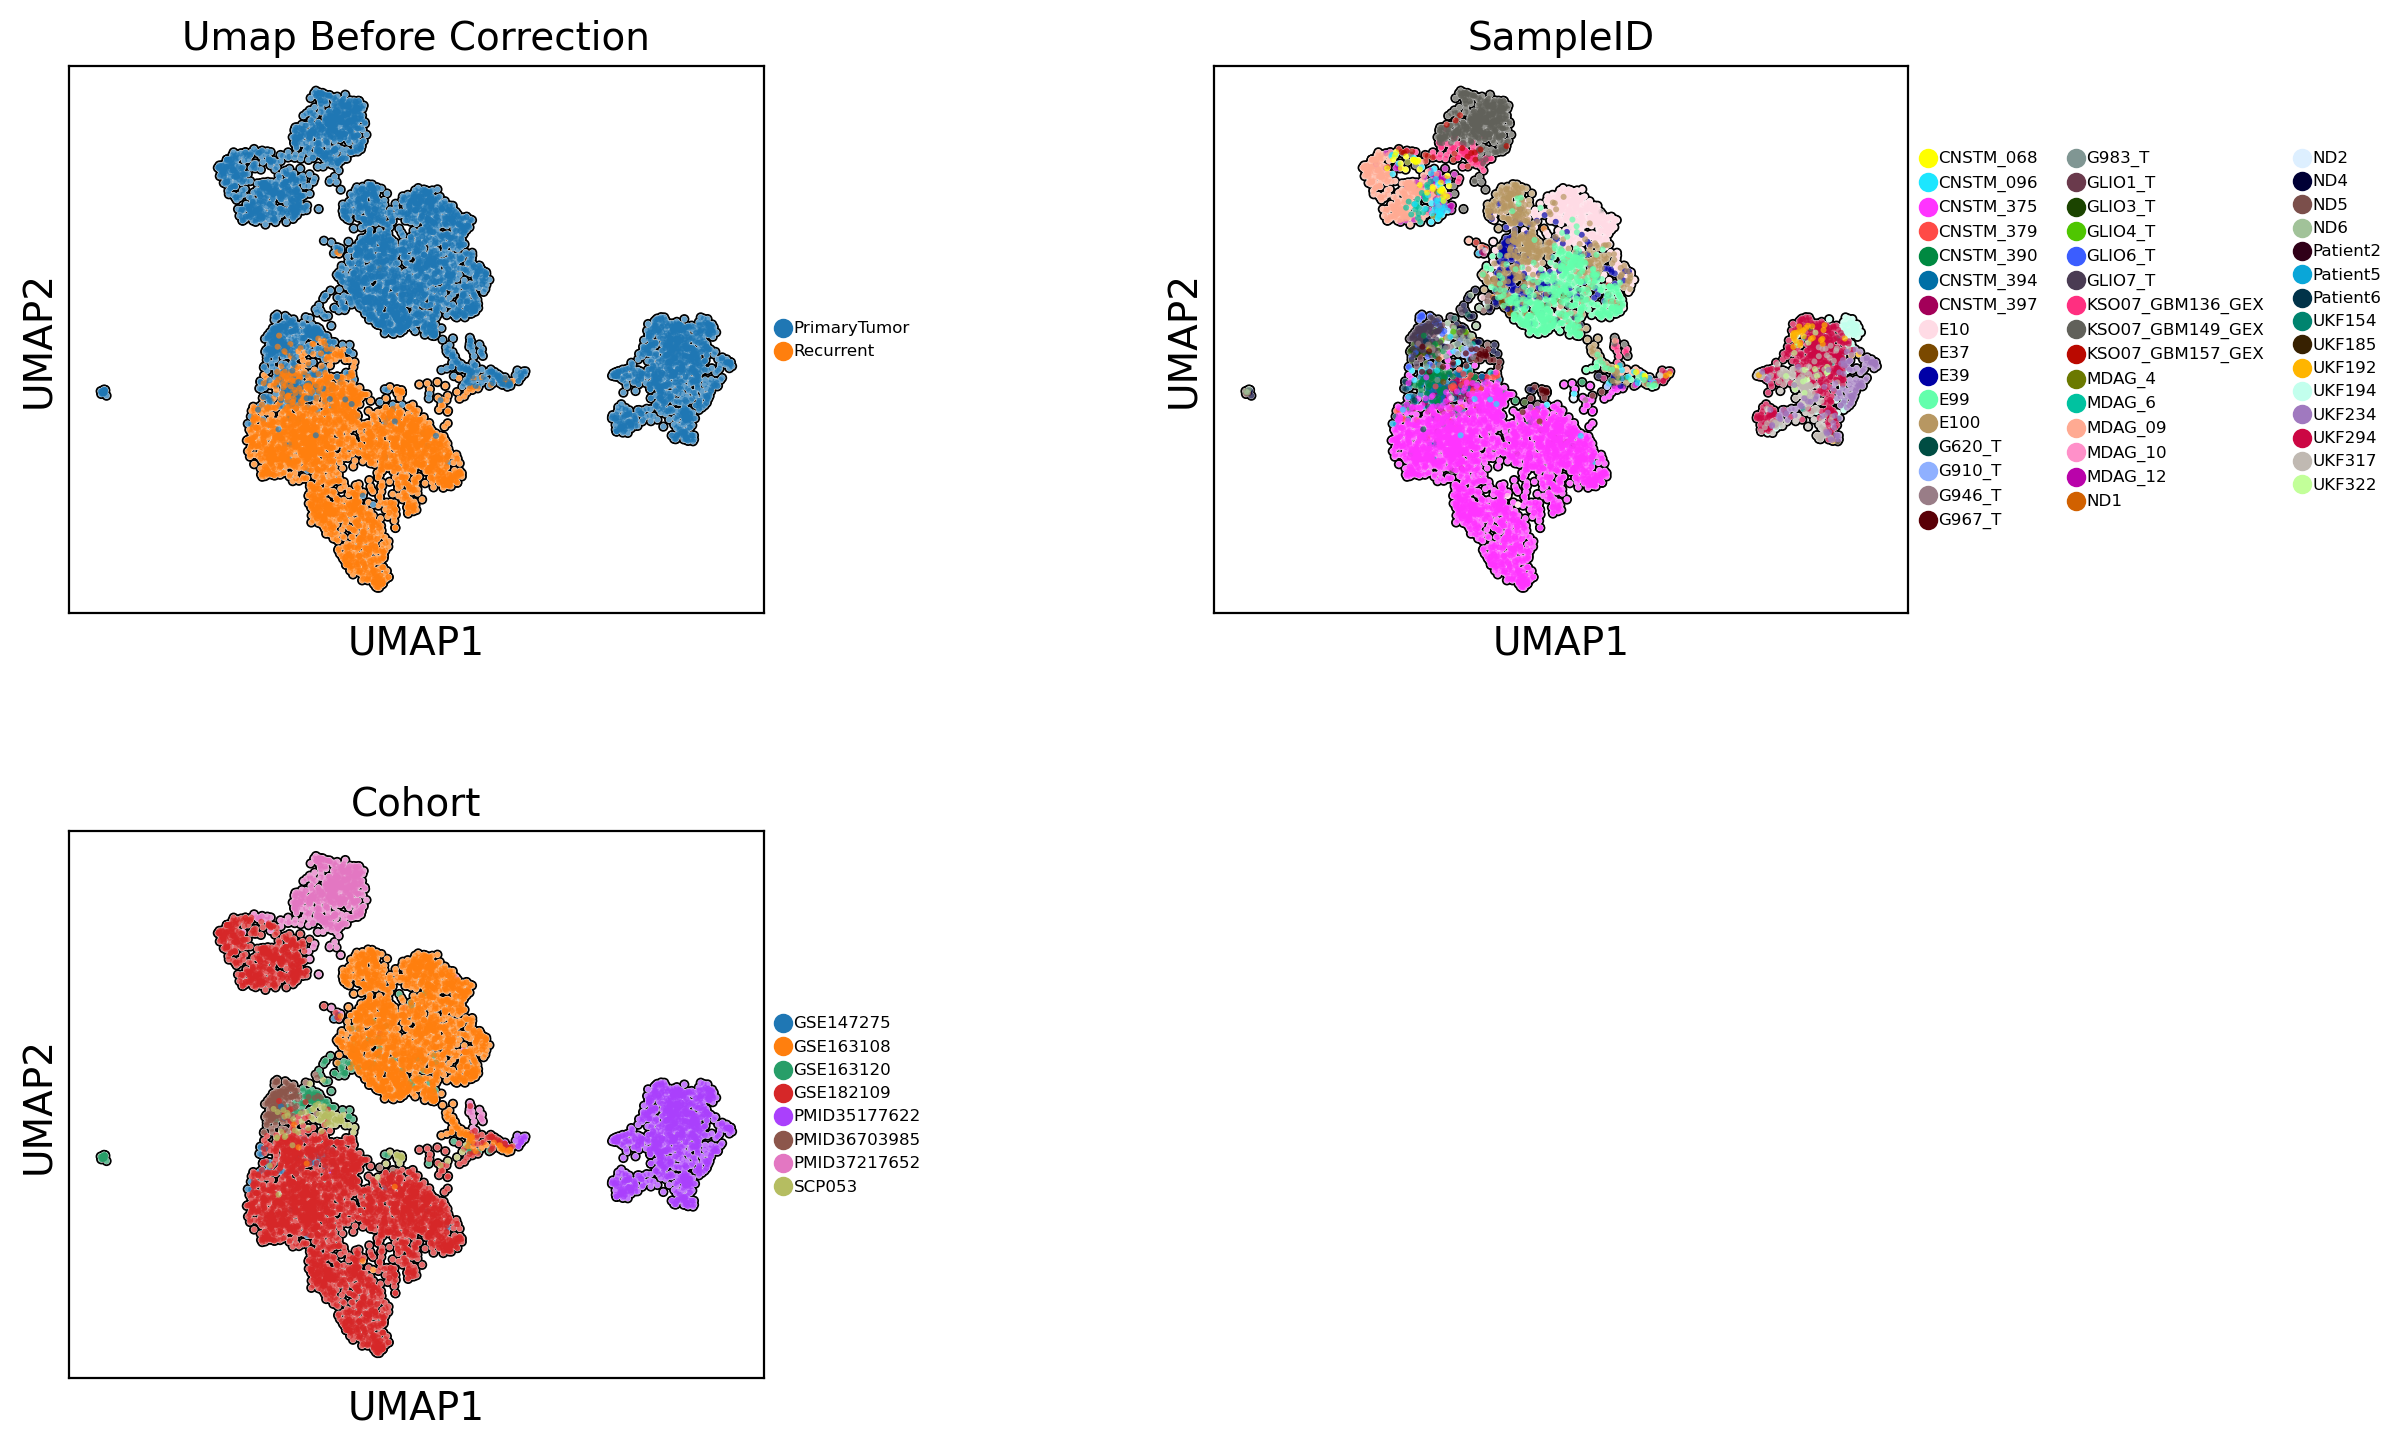

In [10]:
sc.pl.umap(adata, color=['Type','SampleID','Cohort'], legend_fontsize=6, frameon=True, ncols = 2,
                        wspace=.5, hspace=0.4,
           title="Umap Before Correction",add_outline=True)

# Harmony correction

In [11]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata, ['Type','SampleID','Cohort'])

2023-11-28 17:01:55,844 - harmonypy - INFO - Iteration 1 of 10
2023-11-28 17:01:57,214 - harmonypy - INFO - Iteration 2 of 10
2023-11-28 17:01:58,582 - harmonypy - INFO - Iteration 3 of 10
2023-11-28 17:01:59,956 - harmonypy - INFO - Iteration 4 of 10
2023-11-28 17:02:01,326 - harmonypy - INFO - Iteration 5 of 10
2023-11-28 17:02:02,418 - harmonypy - INFO - Iteration 6 of 10
2023-11-28 17:02:03,802 - harmonypy - INFO - Iteration 7 of 10
2023-11-28 17:02:04,592 - harmonypy - INFO - Iteration 8 of 10
2023-11-28 17:02:05,834 - harmonypy - INFO - Iteration 9 of 10
2023-11-28 17:02:06,622 - harmonypy - INFO - Iteration 10 of 10
2023-11-28 17:02:07,472 - harmonypy - INFO - Converged after 10 iterations


# Umap After Harmony Correction

In [12]:
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=0.3)

In [ ]:
sc.pl.umap(adata, color=['Type','SampleID','Cohort','louvain'], legend_fontsize=6, frameon=True, ncols = 2,
                        wspace=.5, hspace=0.4, title="Umap After Correction",add_outline=True)

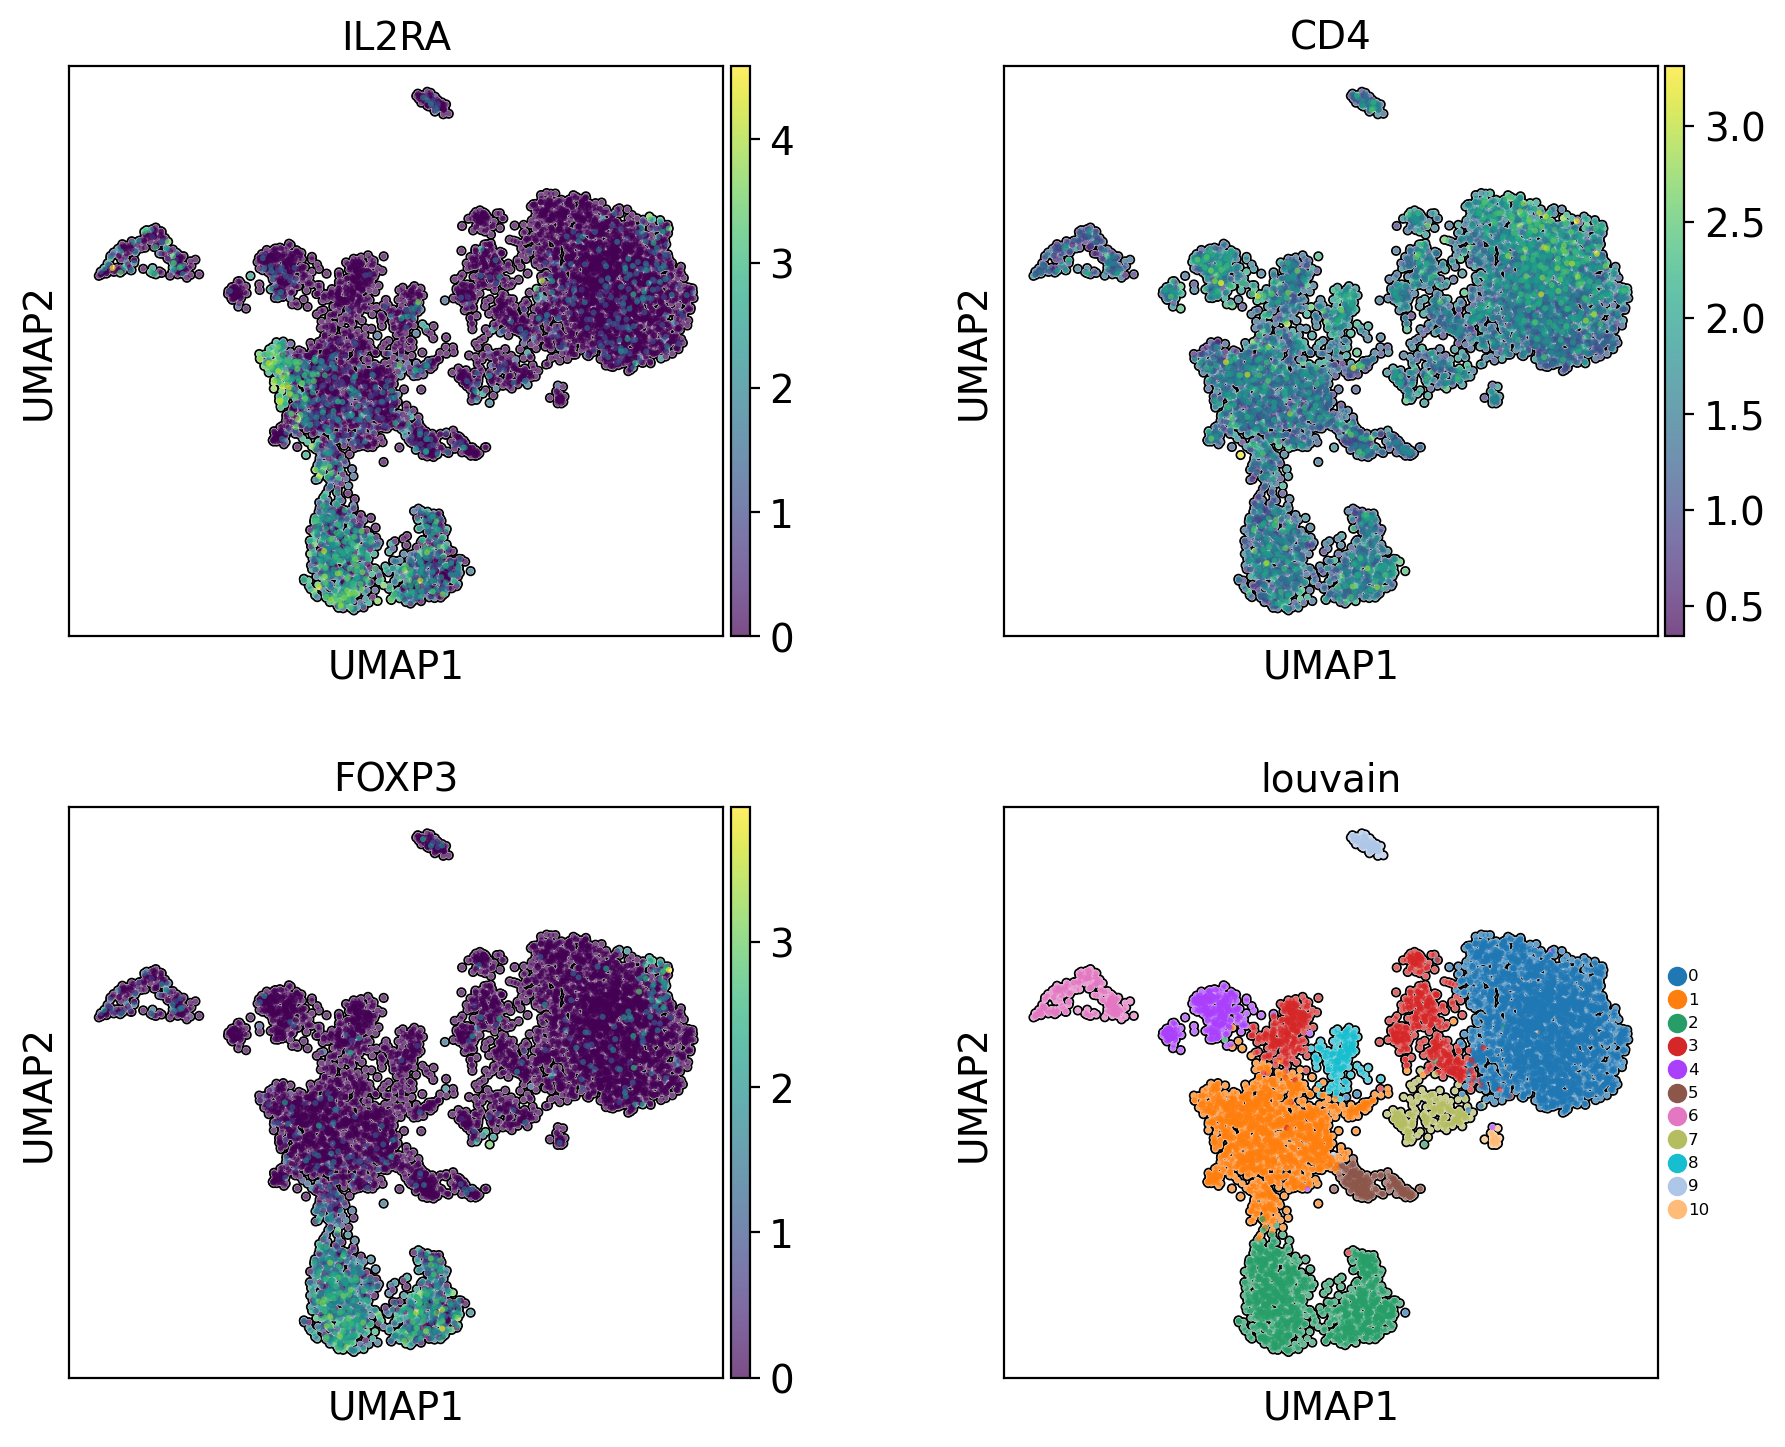

In [14]:
sc.pl.umap(adata, color=["IL2RA", "CD4", "FOXP3","louvain"], legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [ ]:
sc.pl.umap(adata, color=["IL2RA", "CD4", "FOXP3","louvain"], legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

In [17]:
sc.tl.louvain(adata, restrict_to=('louvain', ['2']), resolution=0.5, key_added='louvain_sub')


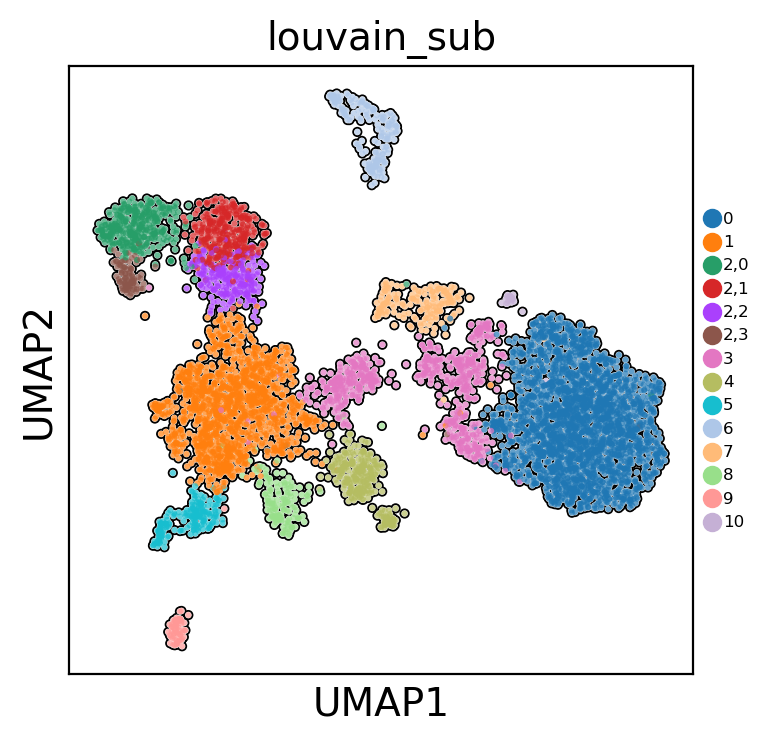

In [18]:
sc.pl.umap(adata, color=["louvain_sub"], legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

In [19]:
annotation_dict = {'0':'Tconv_C0',
                  '1':'Tconv_C1',
                  '3':'Tconv_C3',
                  '4':'Tconv_C4',
                  '5':'Tconv_C5',
                  '6':'Tconv_C6',
                  '7':'Tconv_C7',
                  '8':'Tconv_C8',
                  '9':'Tconv_C9',
                  '10':'Tconv_C10',
                  '2,0':'Treg_C0',
                  '2,1':'Treg_C1',
                  '2,2':'Treg_C2',
                  '2,3':'Treg_C3',
                  }
adata.obs['louvain_sub_renamed'] = [annotation_dict[clust] for clust in adata.obs['louvain_sub']]

In [20]:
annotation_dict2 = {'0':'Tconv',
                  '1':'Tconv',
                  '3':'Tconv',
                  '4':'Tconv',
                  '5':'Tconv',
                  '6':'Tconv',
                  '7':'Tconv',
                  '8':'Tconv',
                  '9':'Tconv',
                  '10':'Tconv',
                  '2,0':'Treg',
                  '2,1':'Treg',
                  '2,2':'Treg',
                  '2,3':'Treg',
                  }
adata.obs['louvain_sub_renamed2'] = [annotation_dict2[clust] for clust in adata.obs['louvain_sub']]

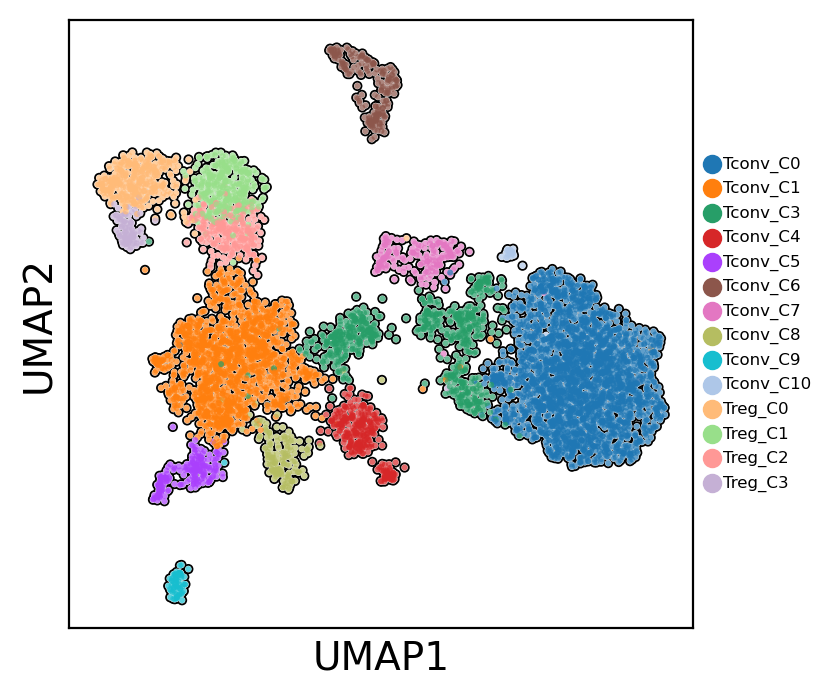

In [21]:
sc.pl.umap(adata, color=["louvain_sub_renamed"], legend_fontsize=6,
           frameon=True, ncols = 2,title="",
                        wspace=.3, hspace=0.3,
                        add_outline=True,save="_first")

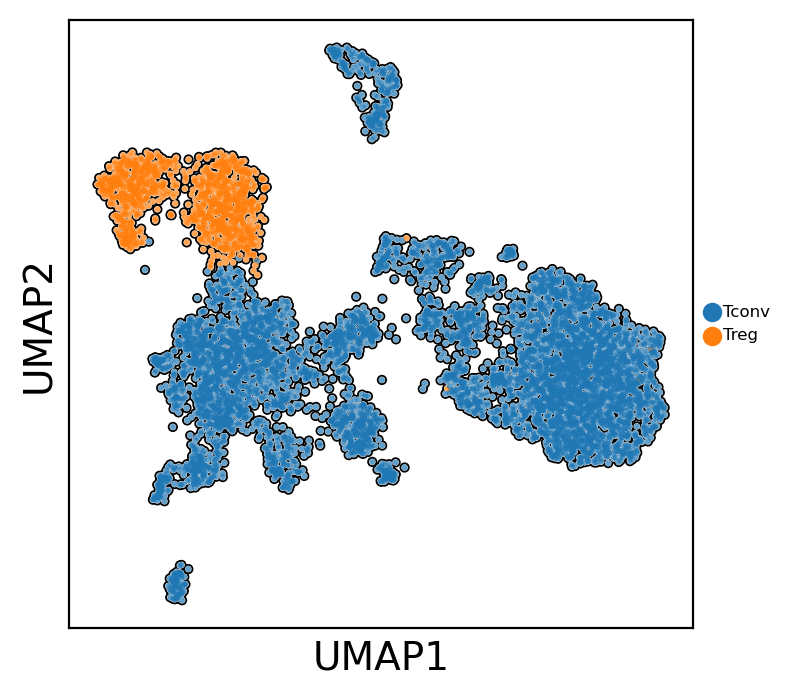

In [22]:
sc.pl.umap(adata, color=["louvain_sub_renamed2"], legend_fontsize=6,
           frameon=True, ncols = 2,title="",
                        wspace=.3, hspace=0.3
                        ,add_outline=True,save="_second")

In [23]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon',pts=0.20)

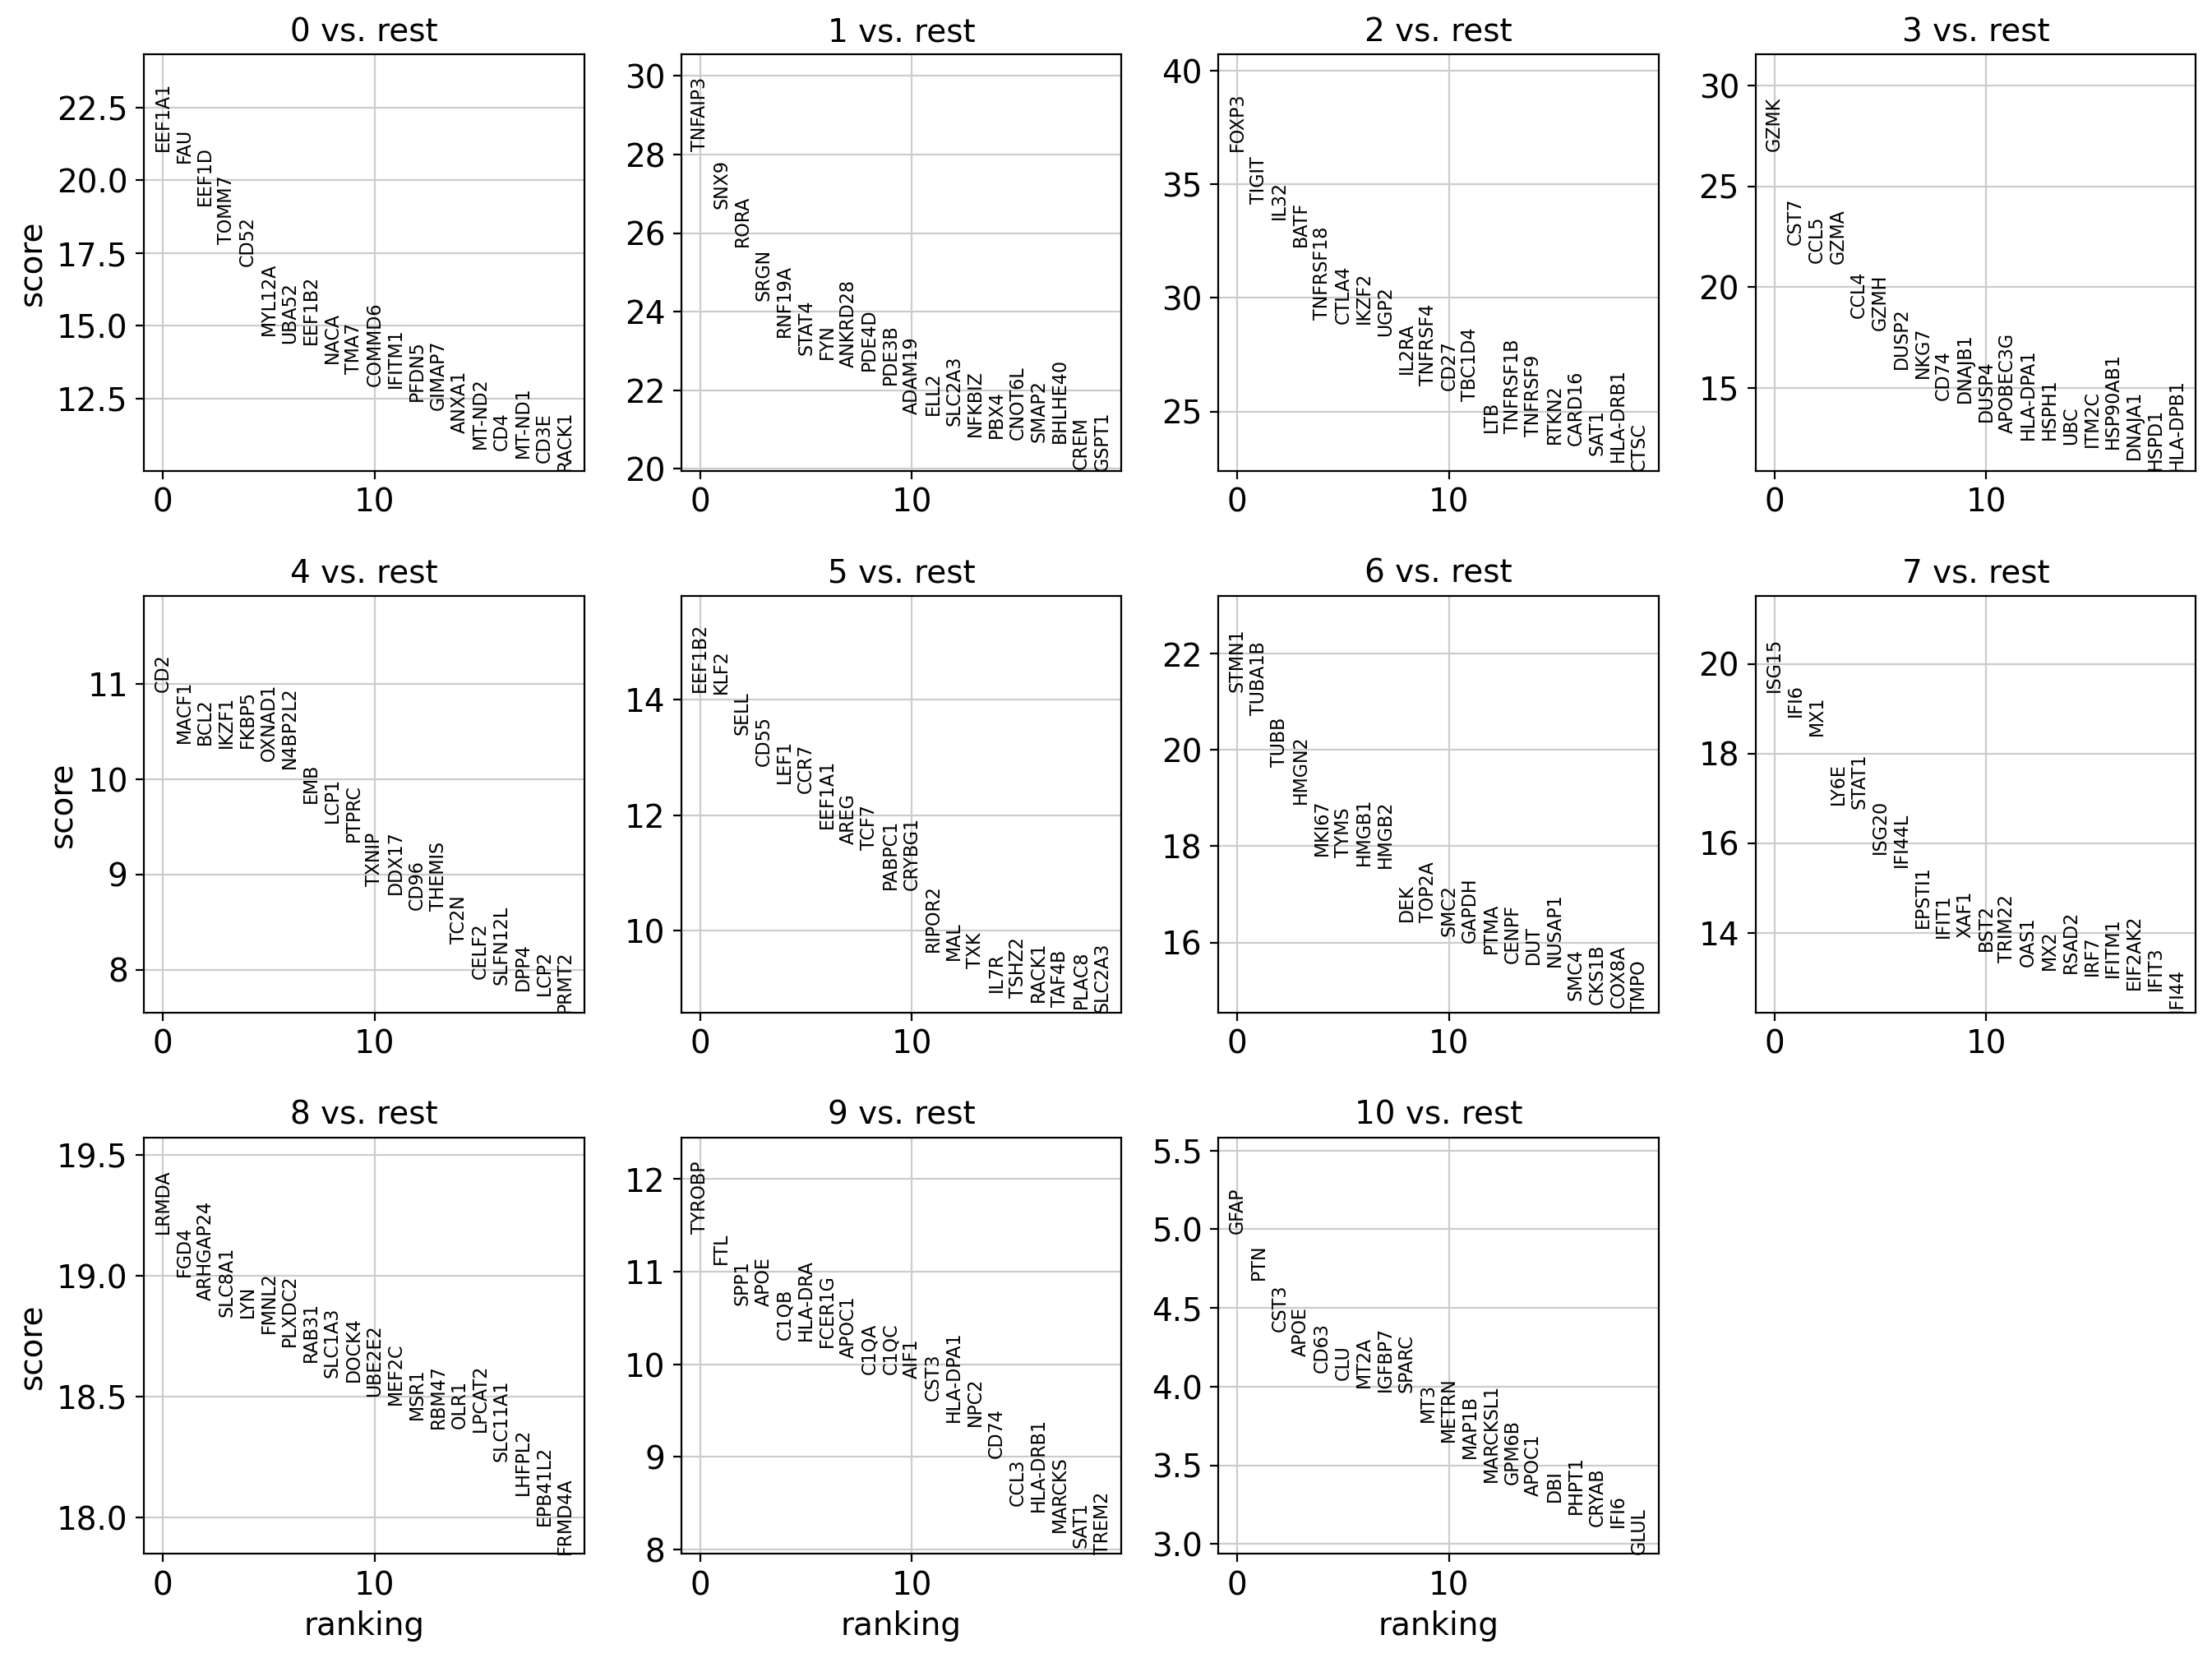

In [24]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# Plot Heatmap

In [25]:
adata = adata[~adata.obs['Sample'].isin(['Patient27']),:]

In [26]:
import cytocipher as cc

In [27]:
adata_all = adata.raw.to_adata()

Added data.uns['louvain_markers']
Added data.obsm['louvain_enrich_scores']


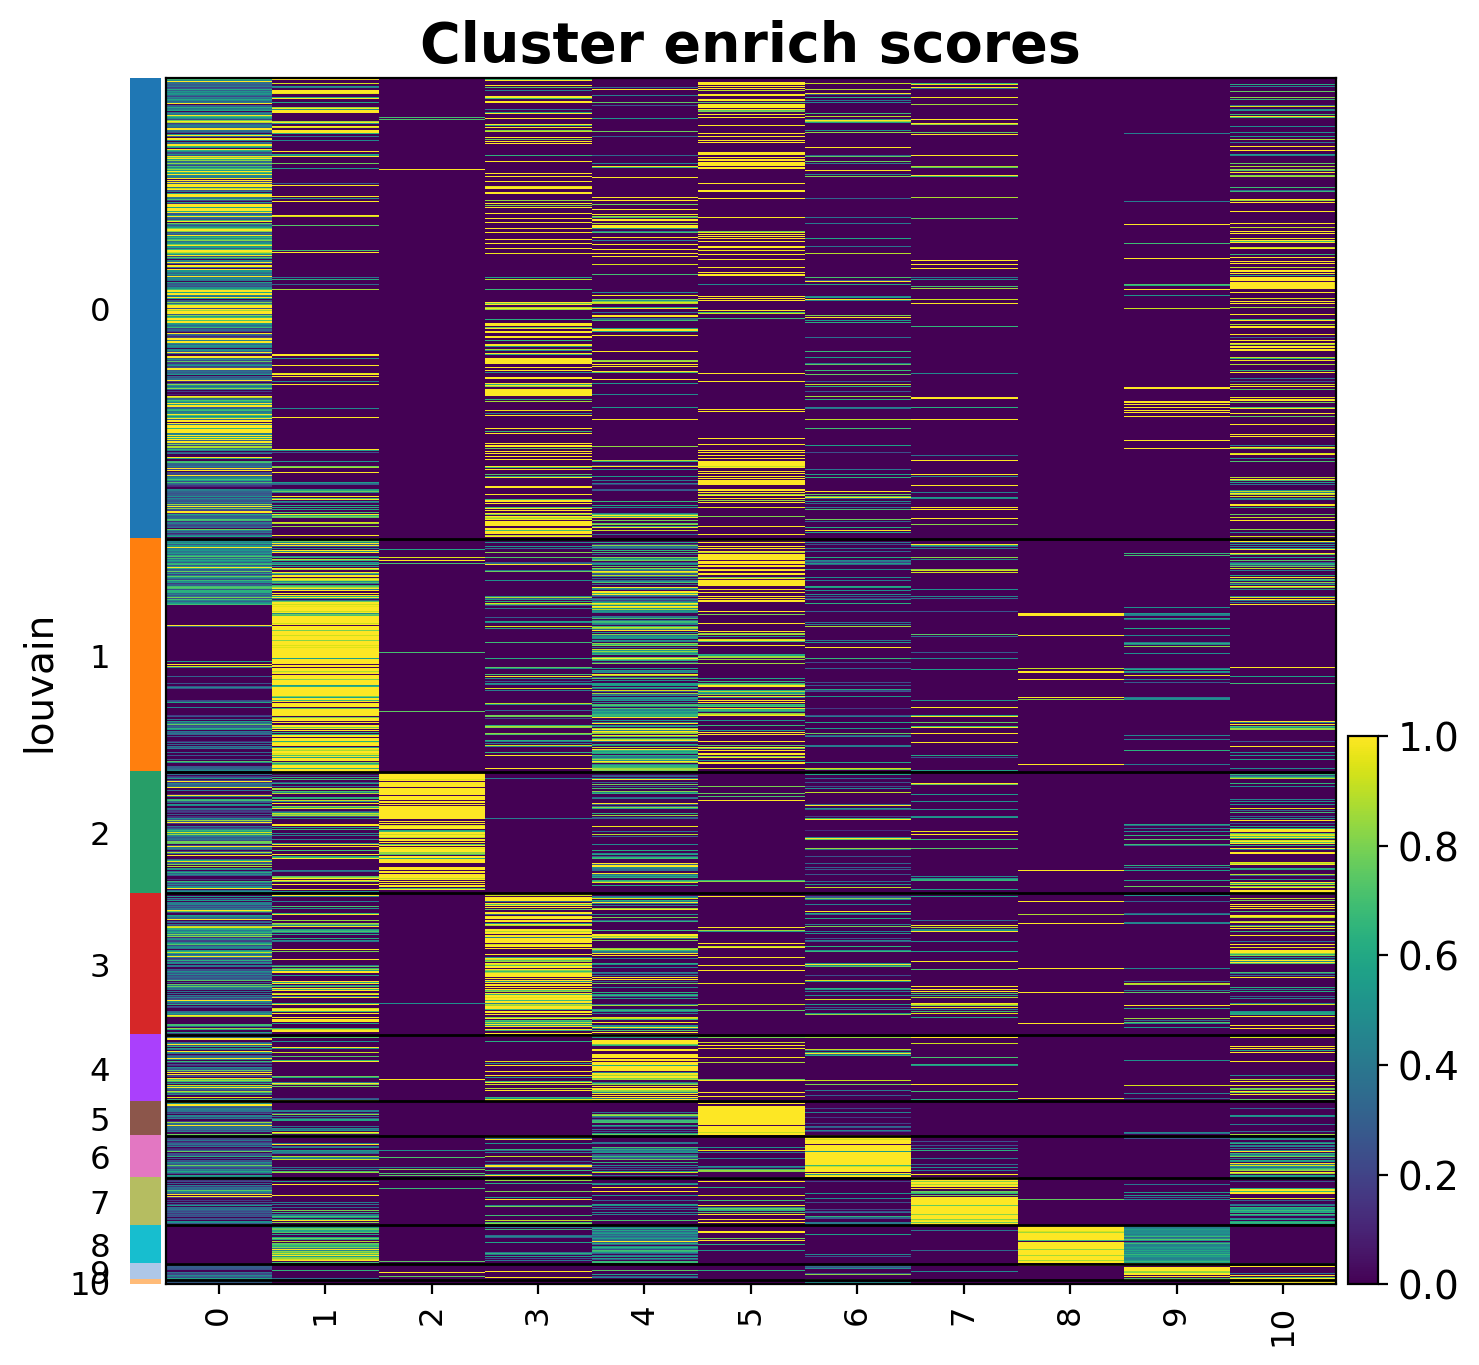

In [28]:
cc.tl.get_markers(adata_all, 'louvain')
cc.tl.code_enrich(adata_all, 'louvain')
cc.pl.enrich_heatmap(adata_all, 'louvain',n_clust_cells=None)

# Export Marker Genes

In [29]:
result = adata.uns['rank_genes_groups']

In [30]:
groups = result['names'].dtype.names
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/CD4_MarkerGenes.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata, group=groups[_]).to_excel(writer, sheet_name=groups[_],index=False)

In [31]:
result = adata_all.uns['rank_genes_groups']

In [32]:
groups = result['names'].dtype.names
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/CD4_DEGS.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata_all, group=groups[_]).to_excel(writer, sheet_name=groups[_],index=False)

# Plot Frequency

## Type

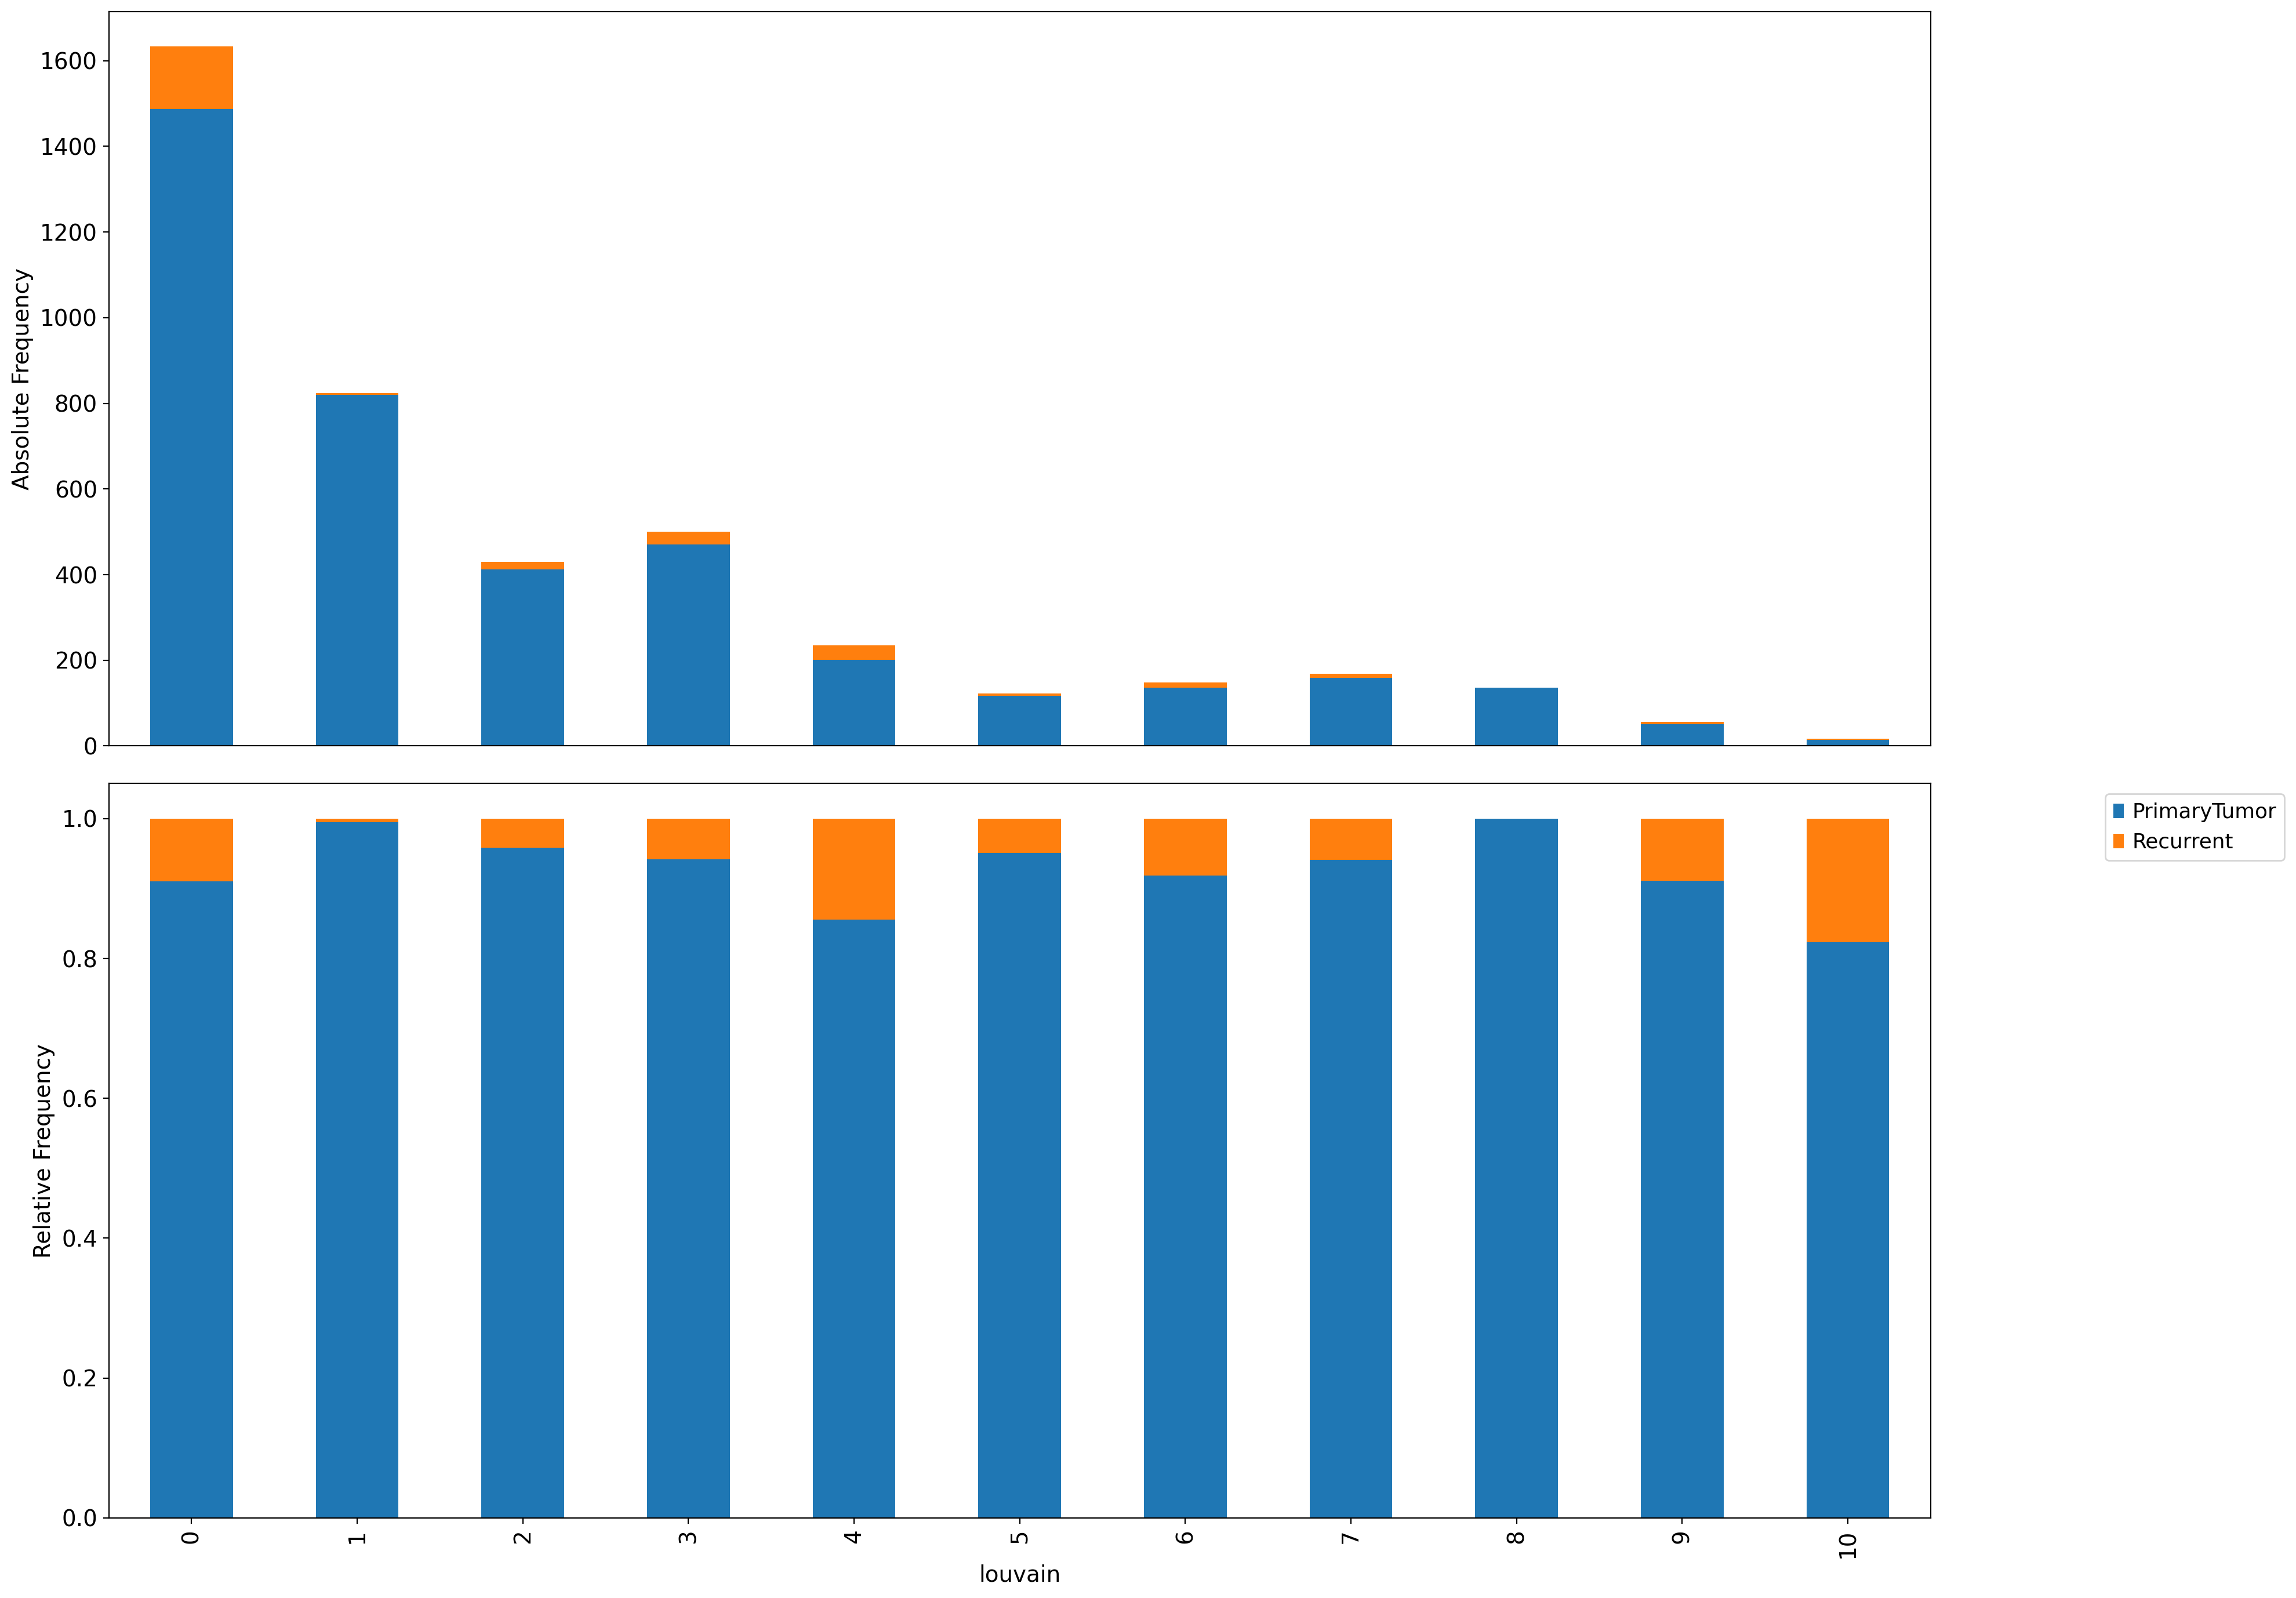

In [33]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("louvain")["Type"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("louvain")["Type"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

In [34]:
#df = pd.DataFrame(adata.obs.groupby("louvain_sub_renamed")["Type","Sample"].value_counts(normalize=True))

In [36]:
df = pd.DataFrame(adata.obs.groupby("louvain_sub_renamed")["Type","Sample"].value_counts(normalize=True).mul(100))

In [37]:
df.to_csv("./test2.csv",sep="\t",header=True,index=True)

In [38]:
adata.obs["Type_Sample"] =adata.obs['Type'].astype("str") + '_' +adata.obs['Sample'].astype("str")

In [39]:
freqs = adata.obs.groupby(["louvain_sub_renamed", "Type_Sample"]).size()



In [40]:
freqs

louvain_sub_renamed  Type_Sample           
Tconv_C0             PrimaryTumor_Patient1      11
                     PrimaryTumor_Patient10     78
                     PrimaryTumor_Patient11     14
                     PrimaryTumor_Patient12    142
                     PrimaryTumor_Patient13      1
                                              ... 
Treg_C3              Recurrent_Patient28         0
                     Recurrent_Patient29         0
                     Recurrent_Patient31         0
                     Recurrent_Patient40         1
                     Recurrent_Patient41         0
Length: 630, dtype: int64

In [41]:
samples = np.unique(adata.obs["louvain_sub_renamed"])


In [42]:
samples

array(['Tconv_C0', 'Tconv_C1', 'Tconv_C10', 'Tconv_C3', 'Tconv_C4',
       'Tconv_C5', 'Tconv_C6', 'Tconv_C7', 'Tconv_C8', 'Tconv_C9',
       'Treg_C0', 'Treg_C1', 'Treg_C2', 'Treg_C3'], dtype=object)

In [43]:
ind = adata.obs["Type_Sample"].astype('category').cat.categories

In [44]:
ind

Index(['PrimaryTumor_Patient1', 'PrimaryTumor_Patient10',
       'PrimaryTumor_Patient11', 'PrimaryTumor_Patient12',
       'PrimaryTumor_Patient13', 'PrimaryTumor_Patient14',
       'PrimaryTumor_Patient15', 'PrimaryTumor_Patient16',
       'PrimaryTumor_Patient17', 'PrimaryTumor_Patient18',
       'PrimaryTumor_Patient19', 'PrimaryTumor_Patient2',
       'PrimaryTumor_Patient20', 'PrimaryTumor_Patient21',
       'PrimaryTumor_Patient22', 'PrimaryTumor_Patient23',
       'PrimaryTumor_Patient24', 'PrimaryTumor_Patient25',
       'PrimaryTumor_Patient26', 'PrimaryTumor_Patient3',
       'PrimaryTumor_Patient30', 'PrimaryTumor_Patient32',
       'PrimaryTumor_Patient33', 'PrimaryTumor_Patient34',
       'PrimaryTumor_Patient35', 'PrimaryTumor_Patient36',
       'PrimaryTumor_Patient37', 'PrimaryTumor_Patient38',
       'PrimaryTumor_Patient39', 'PrimaryTumor_Patient4',
       'PrimaryTumor_Patient42', 'PrimaryTumor_Patient43',
       'PrimaryTumor_Patient44', 'PrimaryTumor_Patient45',
 

In [45]:
relative_frequencies = [freqs[ident] / sum(freqs[ident]) for ident in samples]

In [46]:
relative_frequencies

[Type_Sample
 PrimaryTumor_Patient1     0.006736
 PrimaryTumor_Patient10    0.047765
 PrimaryTumor_Patient11    0.008573
 PrimaryTumor_Patient12    0.086957
 PrimaryTumor_Patient13    0.000612
 PrimaryTumor_Patient14    0.000000
 PrimaryTumor_Patient15    0.000000
 PrimaryTumor_Patient16    0.000000
 PrimaryTumor_Patient17    0.006124
 PrimaryTumor_Patient18    0.000612
 PrimaryTumor_Patient19    0.000612
 PrimaryTumor_Patient2     0.010410
 PrimaryTumor_Patient20    0.000000
 PrimaryTumor_Patient21    0.000612
 PrimaryTumor_Patient22    0.000000
 PrimaryTumor_Patient23    0.000612
 PrimaryTumor_Patient24    0.011635
 PrimaryTumor_Patient25    0.007348
 PrimaryTumor_Patient26    0.025720
 PrimaryTumor_Patient3     0.025720
 PrimaryTumor_Patient30    0.042866
 PrimaryTumor_Patient32    0.001837
 PrimaryTumor_Patient33    0.001837
 PrimaryTumor_Patient34    0.037967
 PrimaryTumor_Patient35    0.003062
 PrimaryTumor_Patient36    0.022658
 PrimaryTumor_Patient37    0.003062
 PrimaryTumor_P

In [47]:
relative_frequencies = pd.DataFrame(relative_frequencies, columns=ind, index=samples).fillna(0)

In [48]:
relative_frequencies = relative_frequencies*100

In [49]:
relative_frequencies

PrimaryTumor_Patient1  PrimaryTumor_Patient10  \
Tconv_C0                0.673607                4.776485   
Tconv_C1                0.000000                0.000000   
Tconv_C10               0.000000                0.000000   
Tconv_C3                0.200000                0.000000   
Tconv_C4                0.000000                0.000000   
Tconv_C5                0.000000                0.000000   
Tconv_C6                0.000000                0.000000   
Tconv_C7                0.591716                1.775148   
Tconv_C8                0.000000                0.000000   
Tconv_C9                3.571429                1.785714   
Treg_C0                 0.000000                0.000000   
Treg_C1                 0.000000                0.000000   
Treg_C2                 0.000000                0.000000   
Treg_C3                 0.000000                0.000000   

           PrimaryTumor_Patient11  PrimaryTumor_Patient12  \
Tconv_C0                 0.857318                8.695652   
Tconv_C1                 3.155340               14.199029   
Tconv_C10                0.000000                0.000000   
Tconv_C3                 4.000000                8.800000   
Tconv_C4                 1.702128                5.531915   
Tconv_C5                 2.439024               11.382114   
Tconv_C6                 6.756757                7.432432   
Tconv_C7                 0.000000               23.076923   
Tconv_C8                 0.000000                0.000000   
Tconv_C9                 0.000000                0.000000   
Treg_C0                  0.675676                2.027027   
Treg_C1                  0.714286                0.000000   
Treg_C2                  1.904762                0.000000   
Treg_C3                  5.405405                2.702703   

           PrimaryTumor_Patient13  PrimaryTumor_Patient14  \
Tconv_C0                 0.061237                0.000000   
Tconv_C1                 0.606796                0.849515   
Tconv_C10                0.000000                0.000000   
Tconv_C3                 0.800000                0.200000   
Tconv_C4                 0.851064                0.000000   
Tconv_C5                 1.626016                0.813008   
Tconv_C6                 0.000000                0.000000   
Tconv_C7                 1.775148                0.000000   
Tconv_C8                 0.000000                1.470588   
Tconv_C9                 0.000000                0.000000   
Treg_C0                  2.702703                0.000000   
Treg_C1                  2.857143                0.000000   
Treg_C2                  1.904762                0.000000   
Treg_C3                  2.702703                0.000000   

           PrimaryTumor_Patient15  PrimaryTumor_Patient16  \
Tconv_C0                 0.000000                0.000000   
Tconv_C1                 0.485437                6.310680   
Tconv_C10                0.000000                0.000000   
Tconv_C3                 0.000000                2.000000   
Tconv_C4                 0.425532                1.276596   
Tconv_C5                 0.000000                3.252033   
Tconv_C6                 0.000000                0.675676   
Tconv_C7                 0.000000                0.591716   
Tconv_C8                 1.470588                5.882353   
Tconv_C9                 0.000000                3.571429   
Treg_C0                  0.000000                0.000000   
Treg_C1                  0.000000                2.857143   
Treg_C2                  0.000000                1.904762   
Treg_C3                  0.000000                0.000000   

           PrimaryTumor_Patient17  PrimaryTumor_Patient18  ...  \
Tconv_C0                 0.612370                0.061237  ...   
Tconv_C1                26.577670                7.766990  ...   
Tconv_C10                0.000000                0.000000  ...   
Tconv_C3                11.400000                1.600000  ...   
Tconv_C4                10.63829

# Cohort

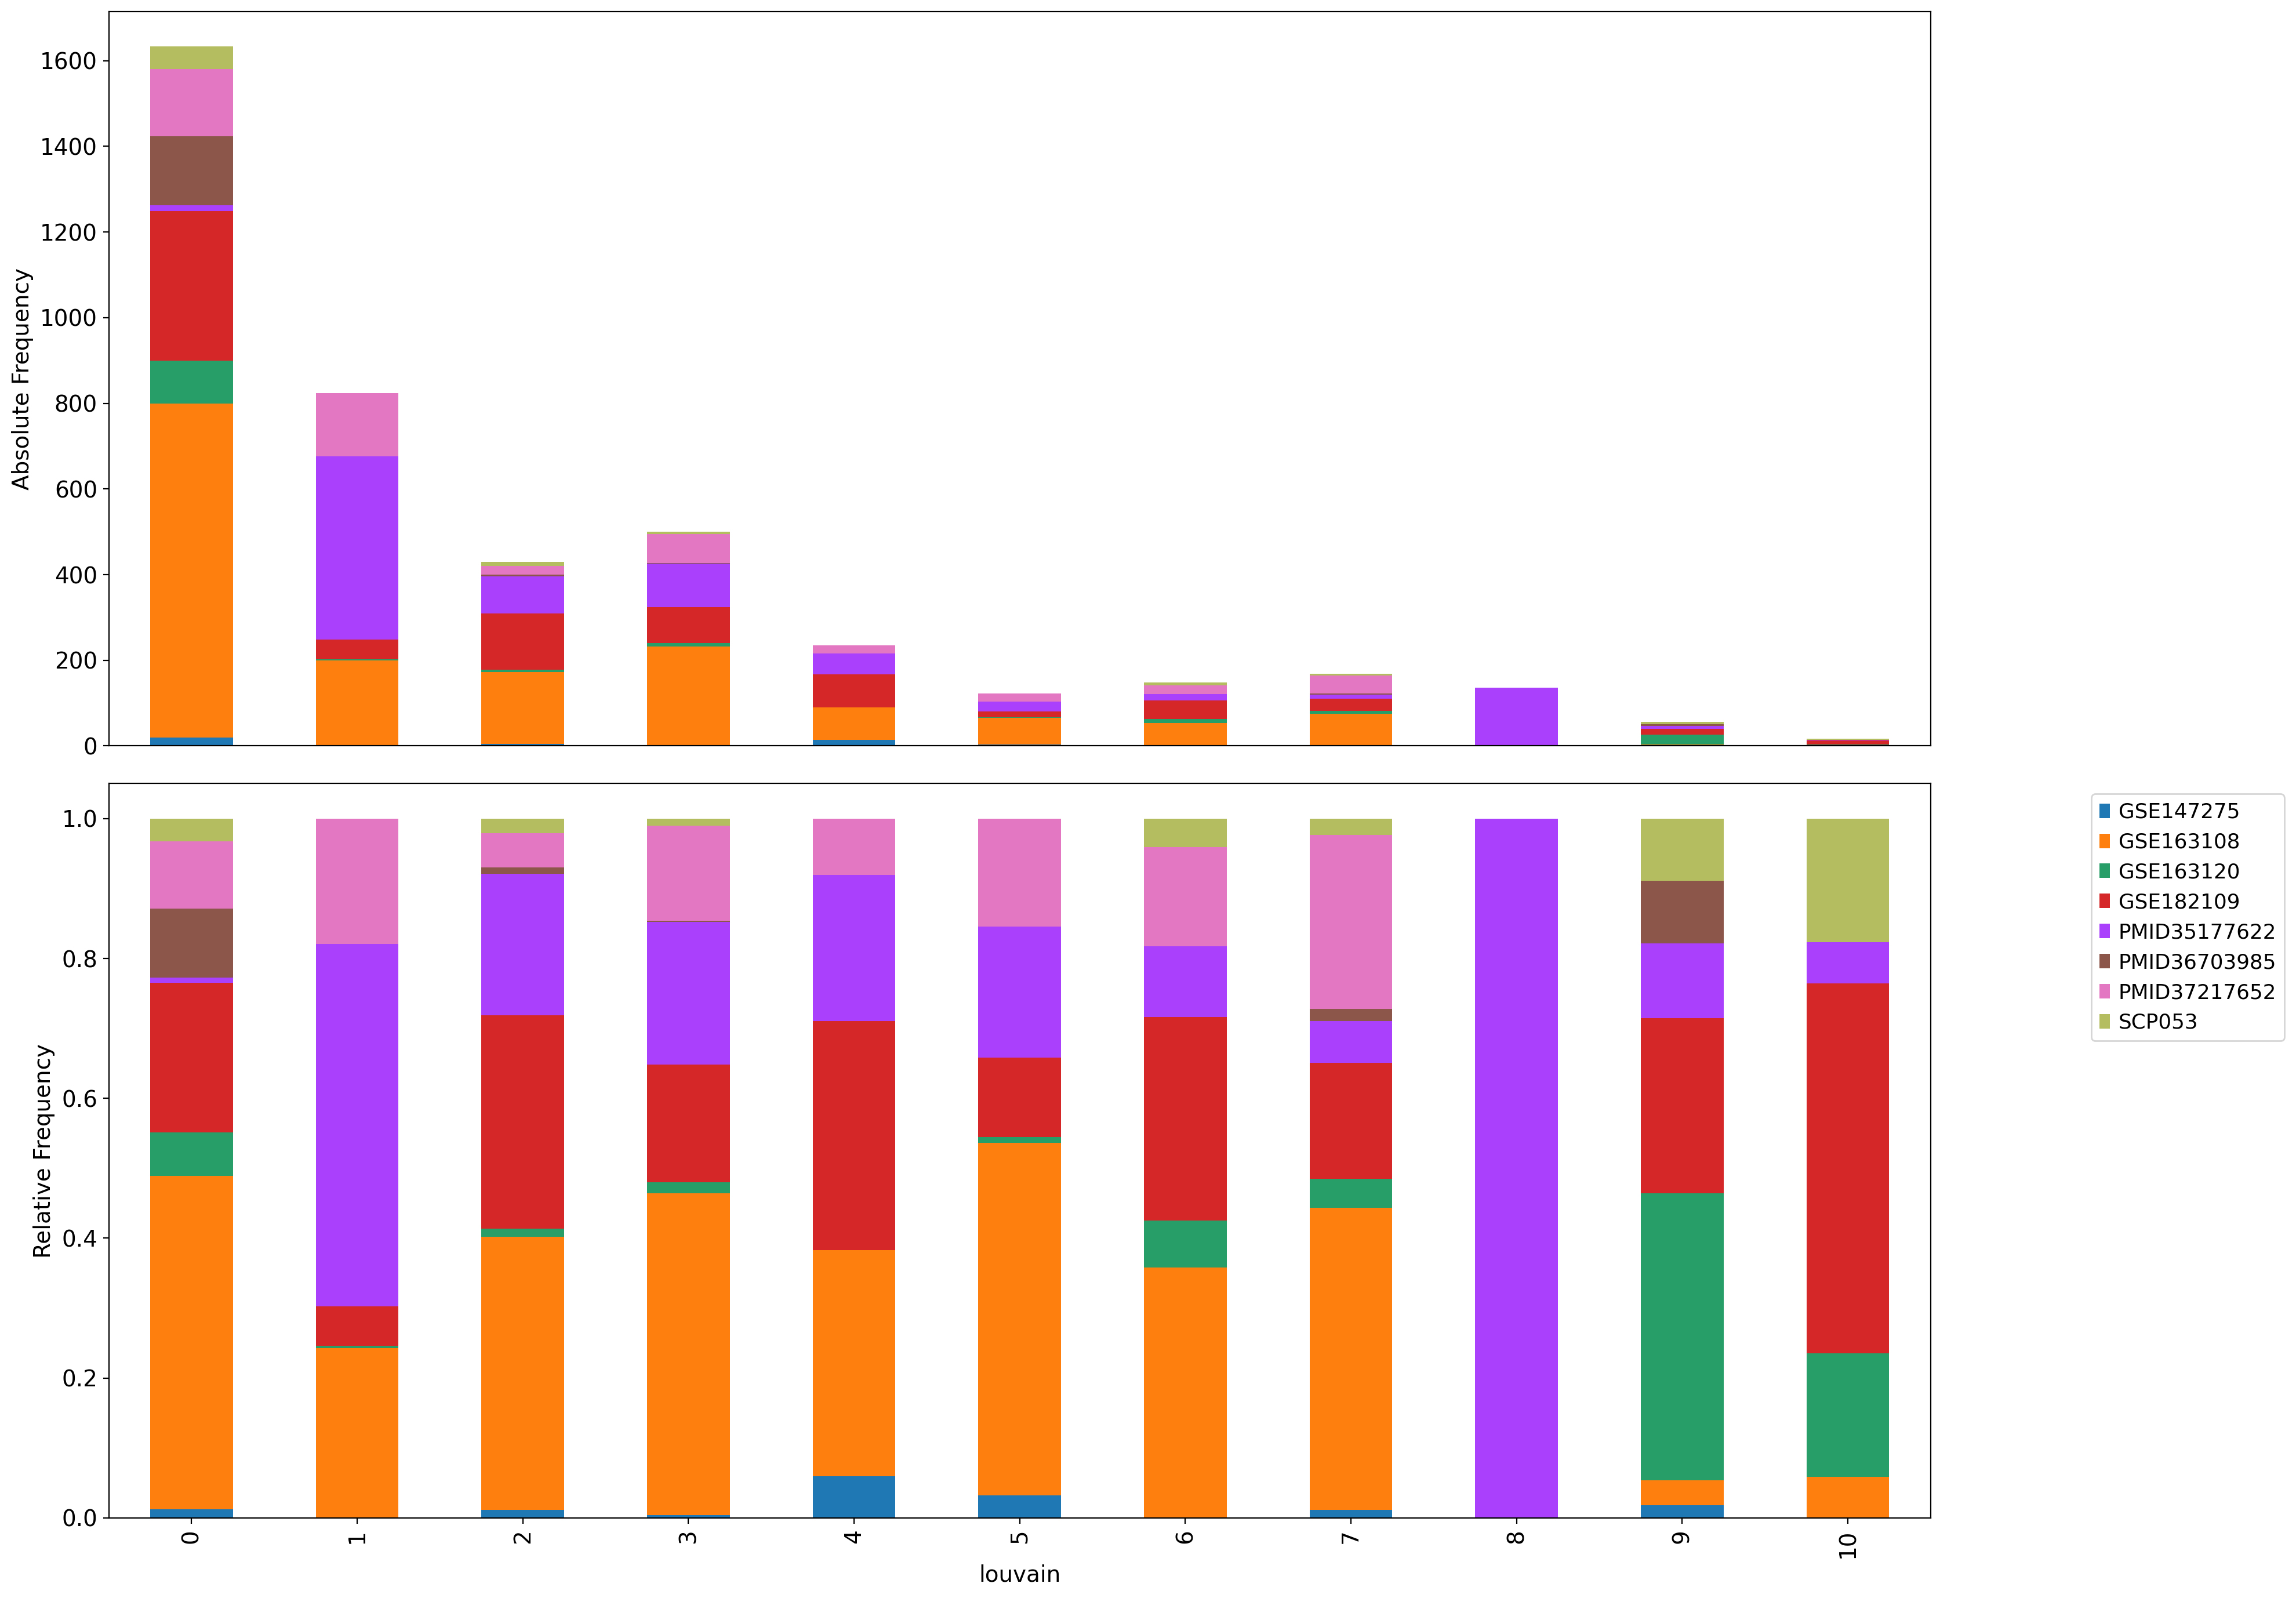

In [50]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("louvain")["Cohort"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("louvain")["Cohort"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

# SampleID

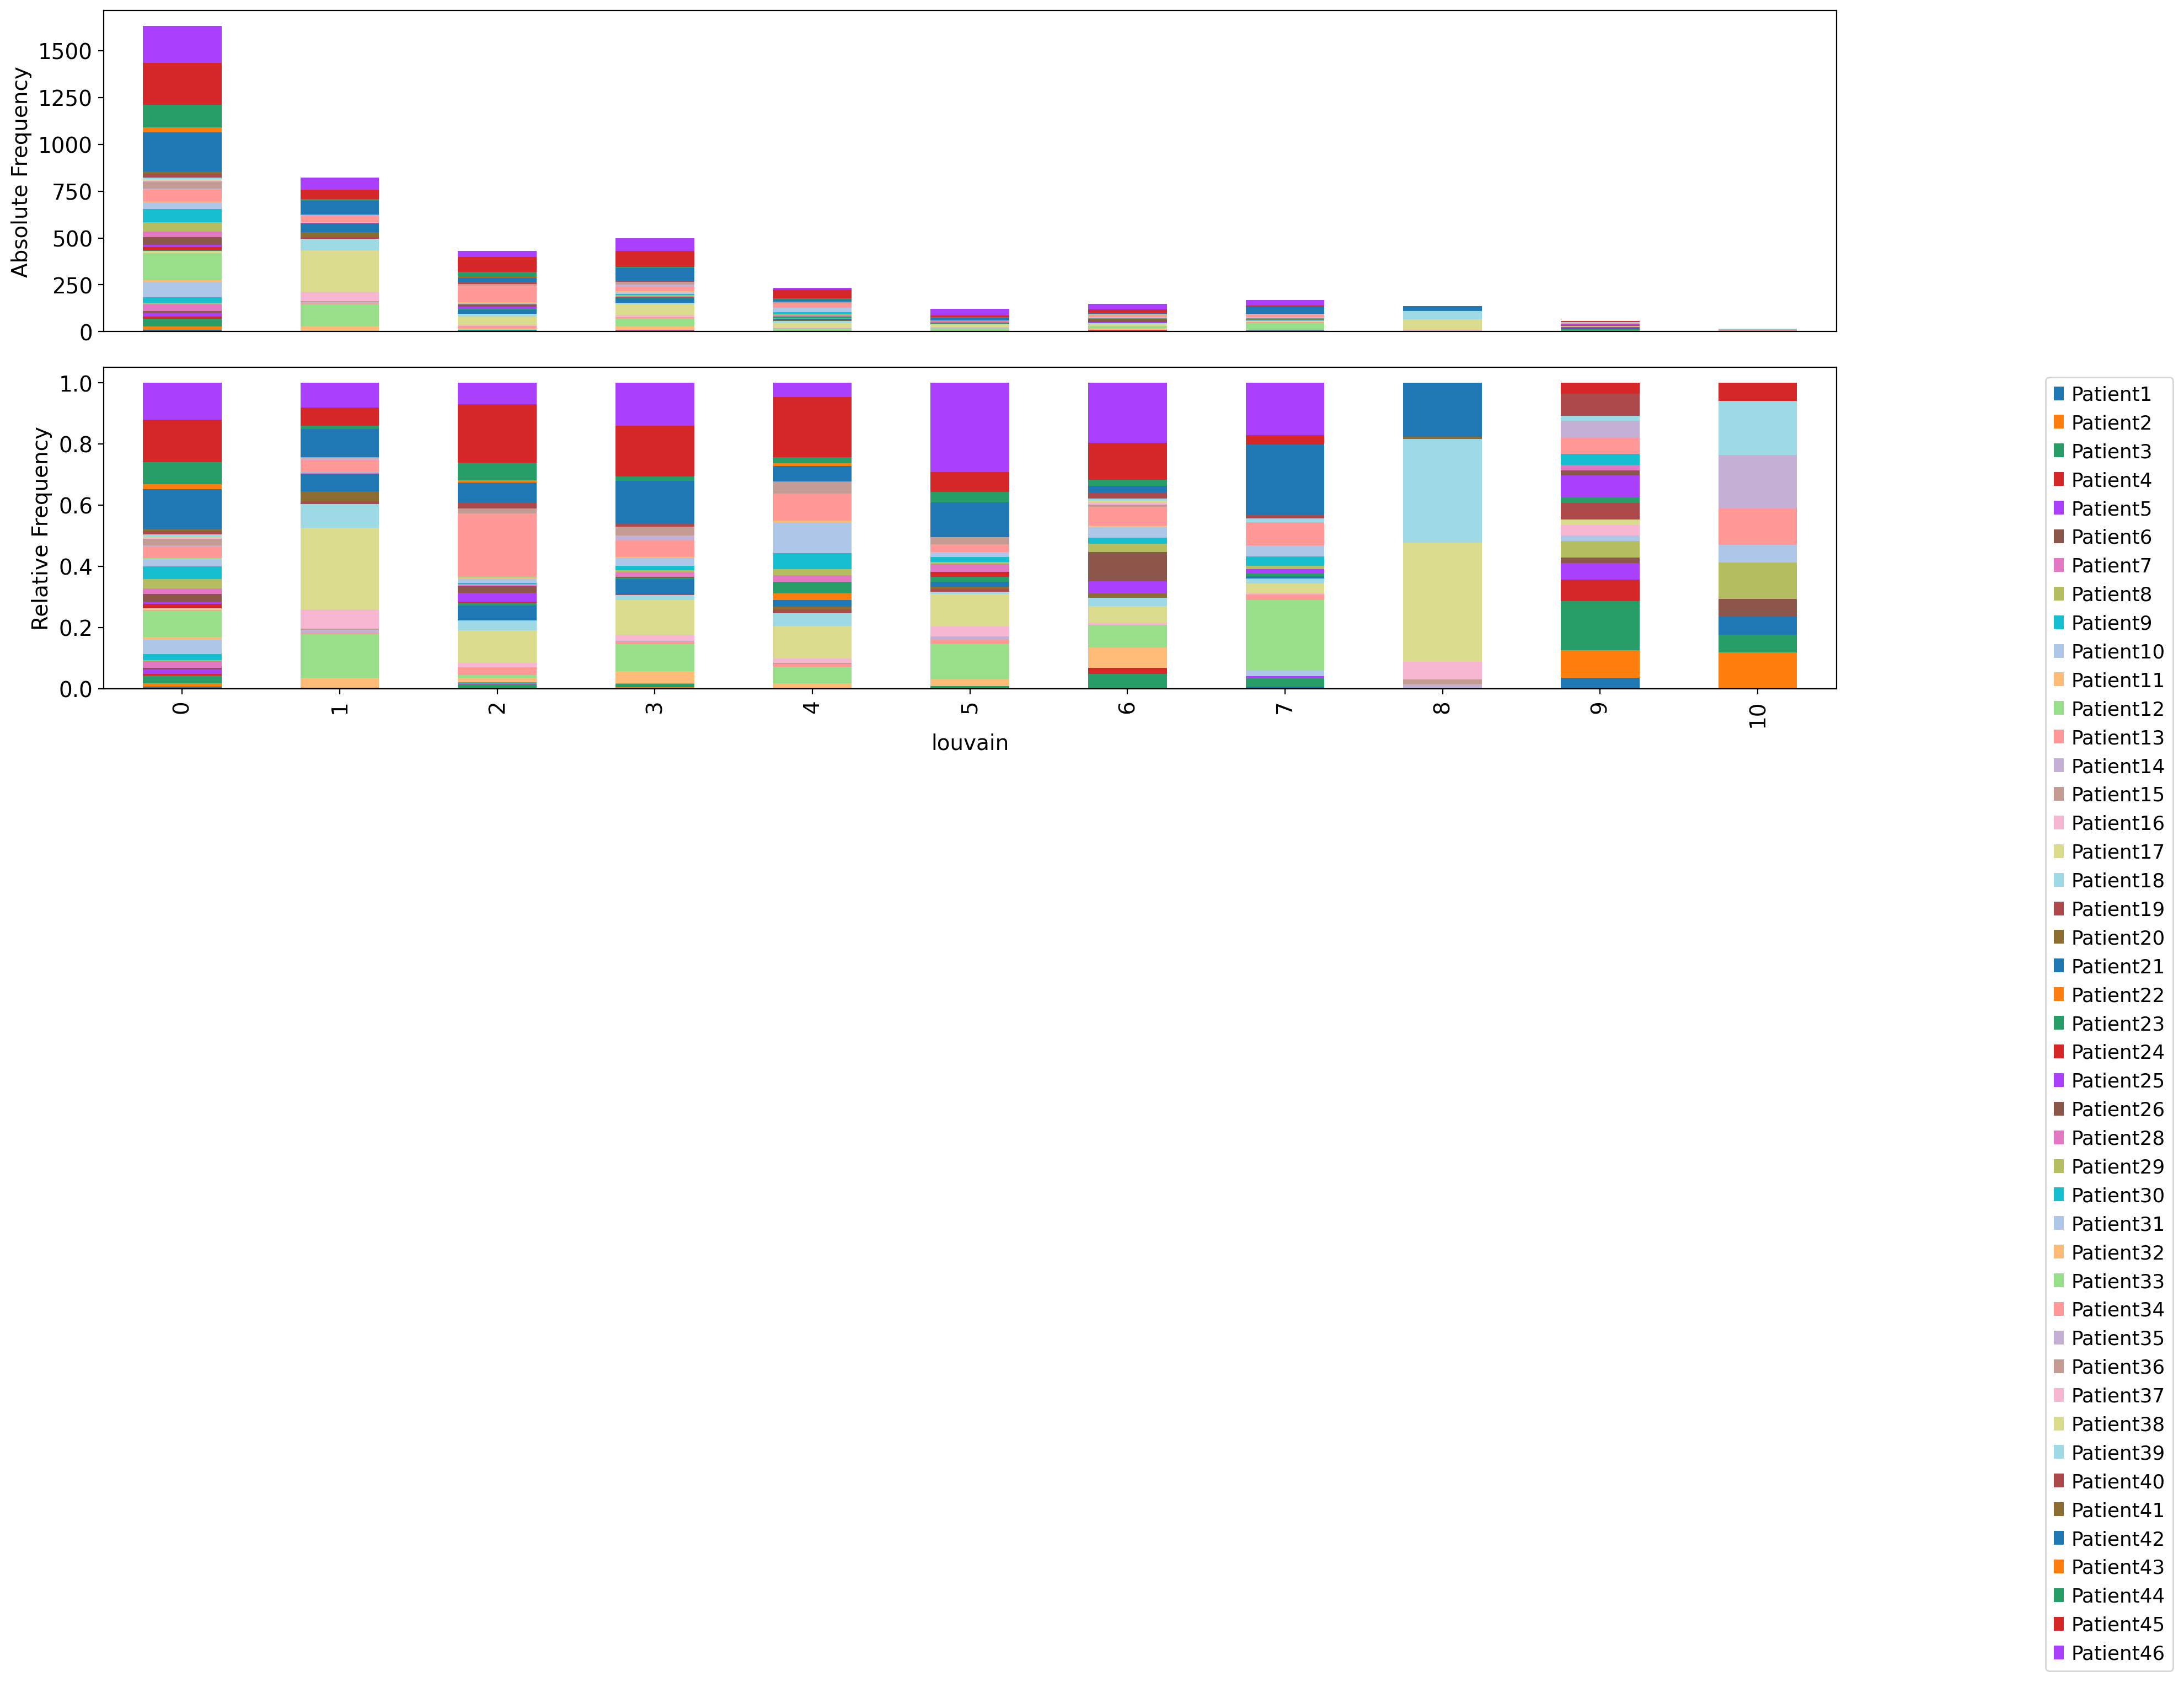

In [51]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("louvain")["Sample"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("louvain")["Sample"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

In [52]:
adata

AnnData object with n_obs × n_vars = 4271 × 3121
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'batch', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'louvain', 'louvain_sub', 'louvain_sub_renamed', 'louvain_sub_renamed2', 'Type_Sample'
    var: 'Gene type', 'Gene description', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'Type_colors', 'SampleID_colors', 'Cohort_colors', 'louvain_colors', 'paga', 'louvain_sizes', 'louvain_sub_colors', 'louvain_sub_renamed_colors', 'louvain_sub_renamed2_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'log', 'log1', 'raw'
    obsp: 'distances', 'connectivities'

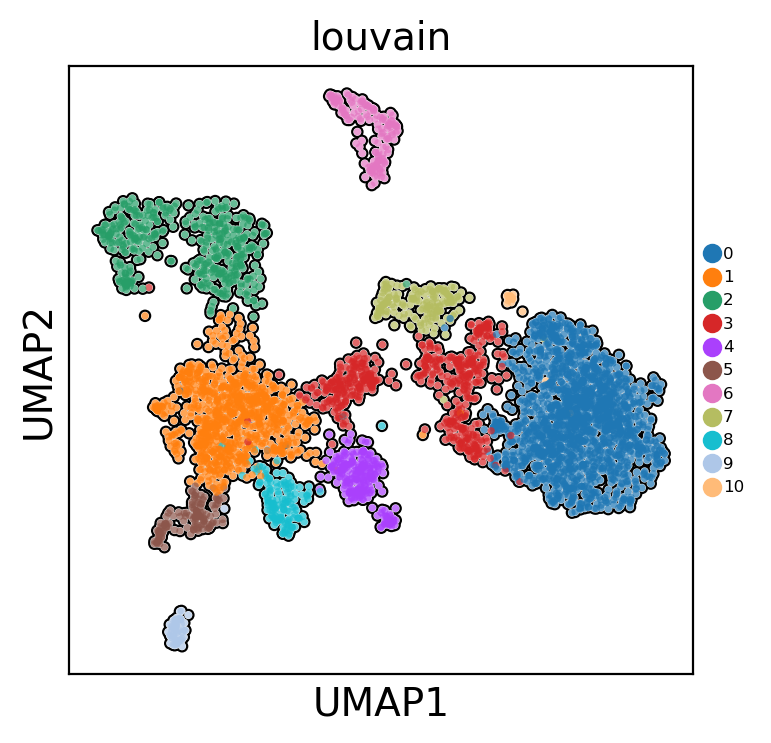

In [54]:
sc.pl.umap(adata, color=["louvain"], legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

In [55]:
TregID = pd.read_csv("/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/H5ad/Treg_cluster_ID.csv",sep="\t",index_col=0)

In [56]:
Treg = adata[adata.obs.index.isin(TregID.index),:]

In [57]:
Tconv = adata[~adata.obs.index.isin(TregID.index),:]

In [58]:
TregID['desc_0.2'] = TregID['desc_0.2'].astype(str)
TregID['desc_0.3'] = TregID['desc_0.3'].astype(str)

In [59]:
Treg.obs['desc_0.2'] = "Treg_C" + TregID['desc_0.2']
Treg.obs['desc_0.3'] = "Treg_C" + TregID['desc_0.3']

In [60]:
Treg.obs.head()

SampleID       GEO_RNA     Cohort          Type       Subtype  \
ND1-572       ND1  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   
ND2-941       ND2  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   
ND4-763       ND4  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   
ND4-1545      ND4  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   
ND4-2651      ND4  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   

             Diagnosis Grade      Location IDH1_Status   EGFR_Status  ...  \
ND1-572   Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   
ND2-941   Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   
ND4-763   Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   
ND4-1545  Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   
ND4-2651  Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   

         doublet_scores predicted_doublets doublet_info louvain louvain_sub  \
ND1-572        0.181818              False        False       0           0   
ND2-941        0.027760              False        False       2         2,0   
ND4-763        0.031390              False        False       2         2,0   
ND4-1545       0.073139              False        False       2         2,0   
ND4-2651       0.141153              False        False       2         2,0   

         louvain_sub_renamed  louvain_sub_renamed2            Type_Sample  \
ND1-572             Tconv_C0                 Tconv  PrimaryTumor_Patient1   
ND2-941              Treg_C0                  Treg  PrimaryTumor_Patient2   
ND4-763              Treg_C0                  Treg  PrimaryTumor_Patient3   
ND4-1545             Treg_C0                  Treg  PrimaryTumor_Patient3   
ND4-2651             Treg_C0                  Treg  PrimaryTumor_Patient3   

         desc_0.2 desc_0.3  
ND1-572   Treg_C0  Treg_C4  
ND2-941   Treg_C0  Treg_C4  
ND4-763   Treg_C0  Treg_C4  
ND4-1545  Treg_C0  Treg_C4  
ND4-2651  Treg_C1  Treg_C1  

[5 rows x 26 columns]

In [61]:
Tconv = Tconv[~Tconv.obs['louvain'].isin(['2']),:]

In [62]:
Tconv.obs['desc_0.2'] = "Tconv_C" + Tconv.obs['louvain'].astype(str)
Tconv.obs['desc_0.3'] = "Tconv_C" + Tconv.obs['louvain'].astype(str)

In [63]:
Tconv.obs.head()

SampleID       GEO_RNA     Cohort          Type       Subtype  \
ND1-11       ND1  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   
ND1-139      ND1  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   
ND1-184      ND1  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   
ND1-261      ND1  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   
ND1-281      ND1  NotAvailable  GSE163120  PrimaryTumor  NotAvailable   

            Diagnosis Grade      Location IDH1_Status   EGFR_Status  ...  \
ND1-11   Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   
ND1-139  Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   
ND1-184  Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   
ND1-261  Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   
ND1-281  Glioblastoma    IV  NotAvailable          WT  NotAvailable  ...   

        doublet_scores predicted_doublets doublet_info louvain louvain_sub  \
ND1-11        0.102894              False        False       0           0   
ND1-139       0.004231              False        False       9           9   
ND1-184       0.005430              False        False       9           9   
ND1-261       0.014371              False        False       0           0   
ND1-281       0.121361              False        False       0           0   

        louvain_sub_renamed  louvain_sub_renamed2            Type_Sample  \
ND1-11             Tconv_C0                 Tconv  PrimaryTumor_Patient1   
ND1-139            Tconv_C9                 Tconv  PrimaryTumor_Patient1   
ND1-184            Tconv_C9                 Tconv  PrimaryTumor_Patient1   
ND1-261            Tconv_C0                 Tconv  PrimaryTumor_Patient1   
ND1-281            Tconv_C0                 Tconv  PrimaryTumor_Patient1   

         desc_0.2  desc_0.3  
ND1-11   Tconv_C0  Tconv_C0  
ND1-139  Tconv_C9  Tconv_C9  
ND1-184  Tconv_C9  Tconv_C9  
ND1-261  Tconv_C0  Tconv_C0  
ND1-281  Tconv_C0  Tconv_C0  

[5 rows x 26 columns]

In [64]:
adata = Tconv.concatenate([Treg],index_unique=None)

# Desc 02

In [69]:
sns.set(rc={'font.family':'Arial', 'font.serif':'Arial'})
sns.set_theme(style="ticks")

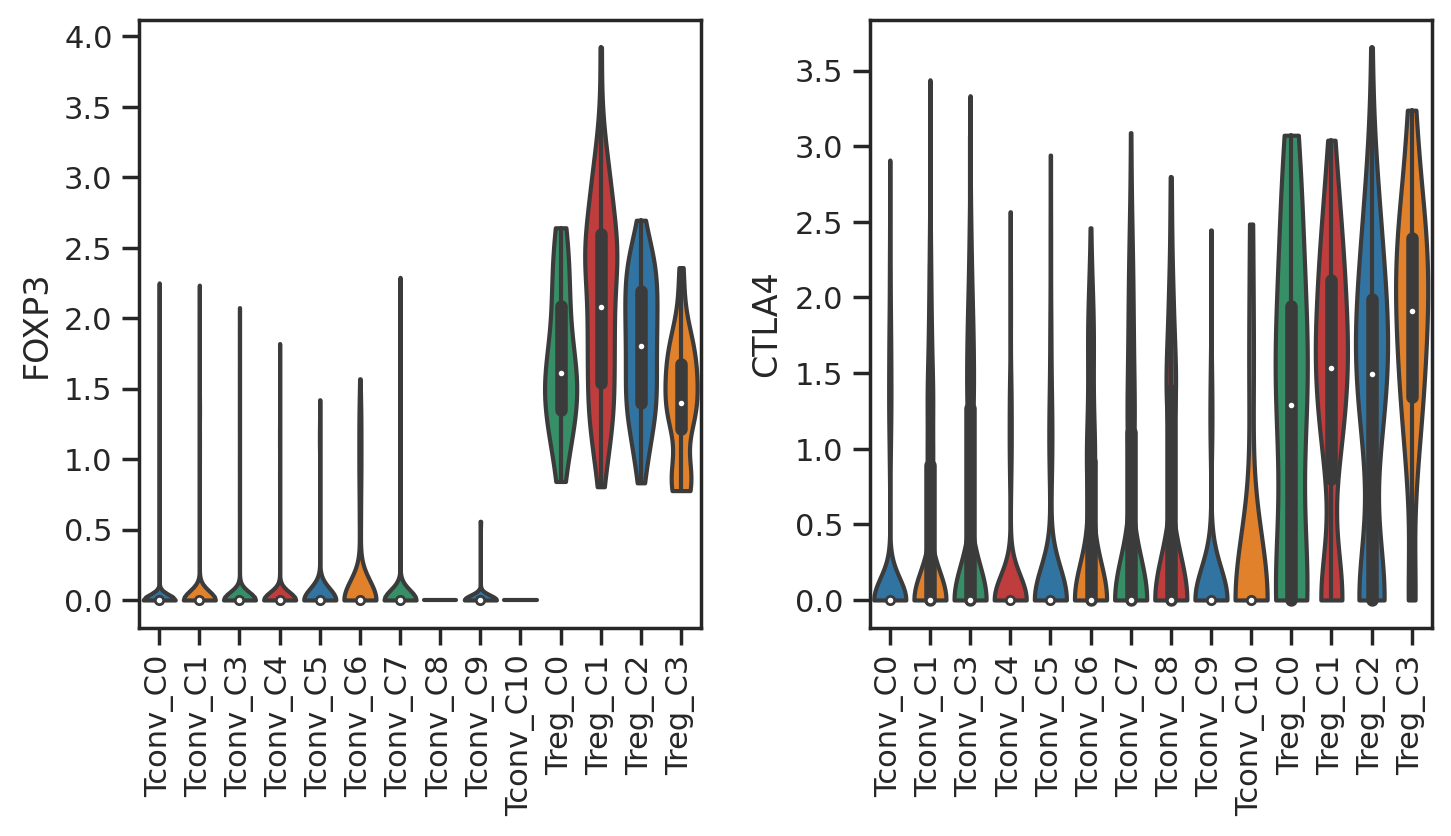

In [75]:
sc.pl.violin(adata, keys=['FOXP3','CTLA4'], groupby='desc_0.2', rotation=90,layer="log",
             palette=['#1f77b4', '#ff7f0e', '#279e68', '#d62728'],use_raw=False,
            stripplot=False, inner='box',save="_FOXP3_CTLA4")


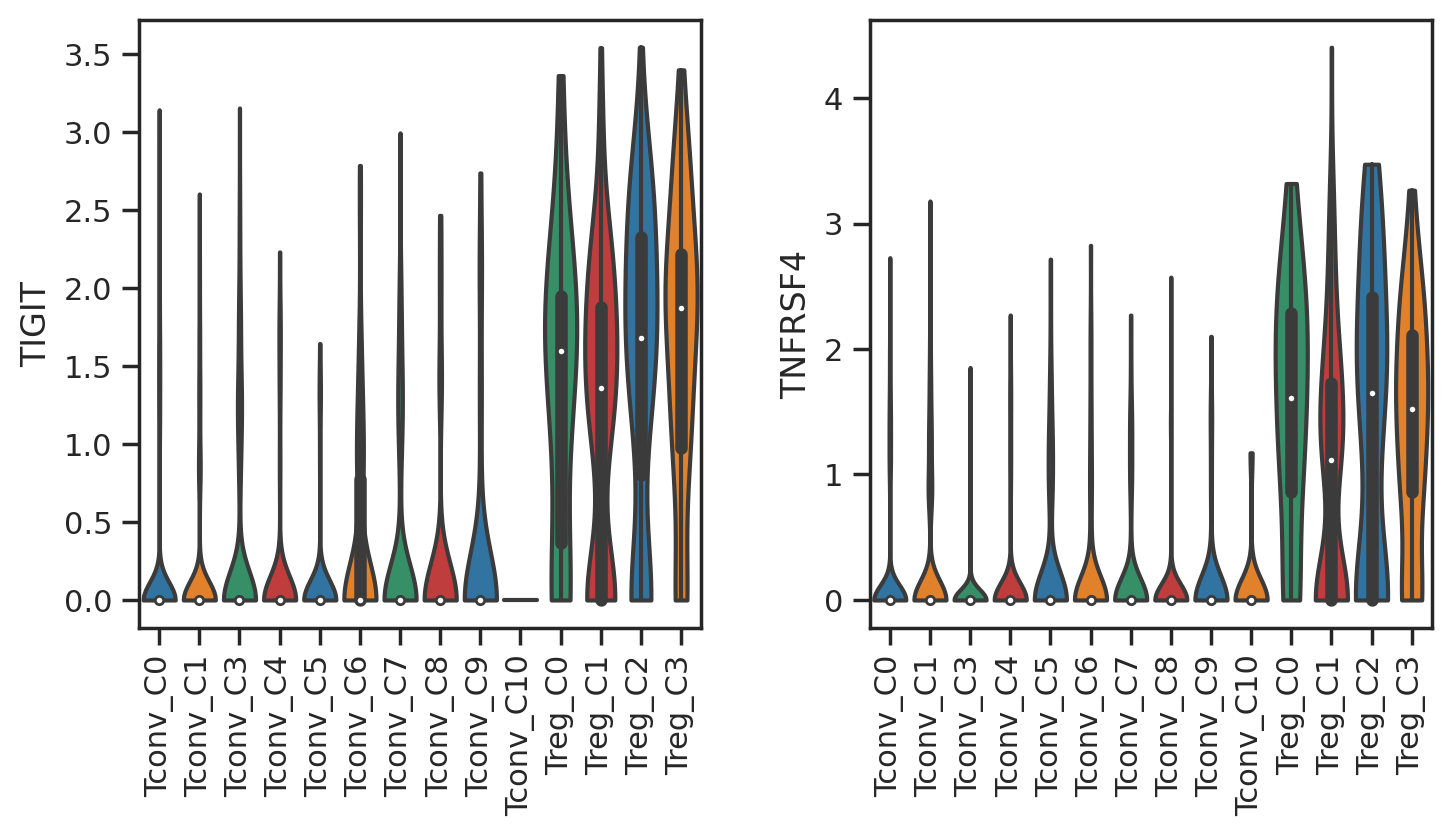

In [76]:
sc.pl.violin(adata, keys=['TIGIT','TNFRSF4'], groupby='desc_0.2', rotation=90,layer="log",
             palette=['#1f77b4', '#ff7f0e', '#279e68', '#d62728'],use_raw=False,
            stripplot=False, inner='box',save="_TIGIT_TNFRSF4")


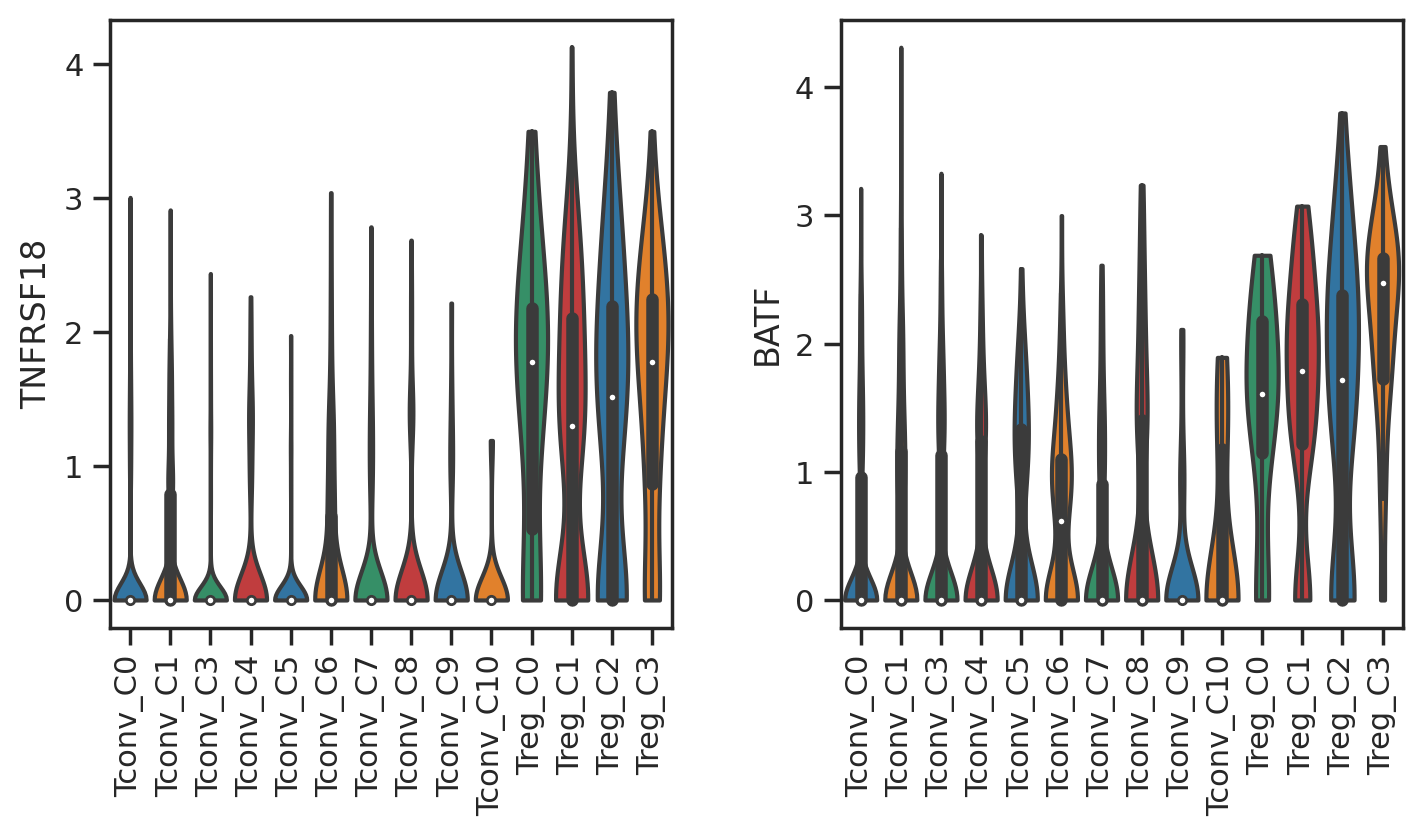

In [77]:
sc.pl.violin(adata, keys=['TNFRSF18','BATF'], groupby='desc_0.2', rotation=90,layer="log",
             palette=['#1f77b4', '#ff7f0e', '#279e68', '#d62728'],use_raw=False,
            stripplot=False, inner='box',save="_TNFRSF18_BATF")


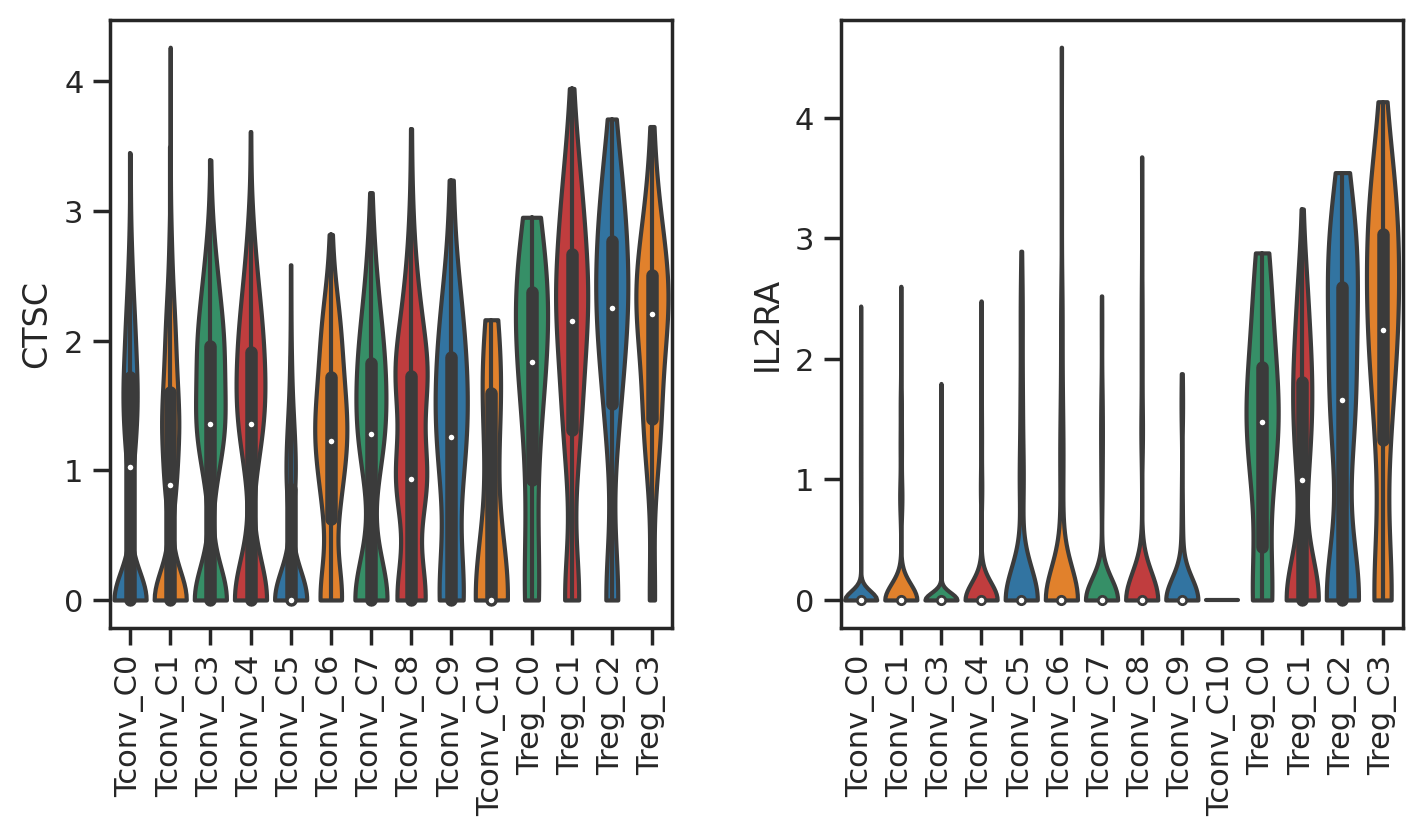

In [78]:
sc.pl.violin(adata, keys=['CTSC','IL2RA'], groupby='desc_0.2', rotation=90,layer="log",
             palette=['#1f77b4', '#ff7f0e', '#279e68', '#d62728'],use_raw=False,
            stripplot=False, inner='box',save="_CTSC_IL2RA")
